<a href="https://colab.research.google.com/github/junranshi/capstone_moonboard/blob/main/VAE_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info
In this notebook, I use Variational Autoencoders to generate new routes on the MoonBoard. The entire dataset contains 25,099 routes ranging in grades from 0 to 6, which maps to V4-V10+ in actual route grades.  
My final (as of December 9th) model can be found at the end of the notebook. It has a very simple structure, taking inputs of (18, 11, 3) with the 3 channels corresponding to whether a hold is a start, mid, or finish hold. The model uses 20 latent variables. After conducting some experiments to find the best setup for training, I decided to train grade-based models using very small samples (n=500). Please find outputs at the end of the notebook.

In [2]:
from sklearn.model_selection import train_test_split

from tensorflow import keras # for building Neural Networks
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Reshape
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

import numpy as np
import pandas as pd
import sys
import os
import pickle
import random

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
import graphviz # for showing model diagram
import plotly
import plotly.express as px # for data visualization

import cv2

In [3]:
!git clone https://github.com/junranshi/capstone_moonboard.git

fatal: destination path 'capstone_moonboard' already exists and is not an empty directory.


In [4]:
py_file_location = "/content/capstone_moonboard/data"
sys.path.append(os.path.abspath(py_file_location))

with open('/content/capstone_moonboard/data/cleaned.p', 'rb') as f:
    mb_2016 = pickle.load(f)

from helper import *

mb_2016_img = cv2.imread('/content/capstone_moonboard/images/mb_2016_img.jpeg')

Number of routes after scraping: 30642
Number of routes after cleaning: 25099


In [5]:
%cd /content/capstone_moonboard
!git pull

/content/capstone_moonboard
Already up to date.


#Functions

In [49]:
def get_coor(hold):
    x, y = hold
    x_coor = 94 + x*51
    y_coor = 958 - y*51
    return (int(x_coor), int(y_coor))

def add_hold(hold, img, hold_type='mid'):
    """
    add hold to moonboard image
    """
    circle_color = {
        'start': (0,255,0),
        'mid': (255,0,0),
        'end': (0,0,255),
    }
    center = get_coor(hold)
    c = circle_color[hold_type]
    cv2.circle(img = img, center = center, radius = 28, color = c, thickness=5)

def display_route_flat(route):
    """
    display an entire route on an image
    """
    img = mb_2016_img.copy()
    for hold in route:
        add_hold(hold, img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# example:
# r = {'start': [[0,0]], 'mid': [[2,2], [6,6]], 'end': [[0,17],[4,17]]}
# display_route(r)

def draw_samples(data, n):
    """
    draw n samples of routes from data (dictionary)
    """
    samples = {}
    for item in random.sample(list(data.items()), n):
        samples[item[0]] = item[1]
    return samples

def get_X_y(samples):
    X_start = get_matrices(samples, ['start'])[1]
    X_mid = get_matrices(samples, ['mid'])[1]
    X_end = get_matrices(samples, ['end'])[1]

    X = np.zeros((len(samples), 18, 11, 3))
    for i in range(len(samples)):
      sample = np.dstack((X_start[i], X_mid[i], X_end[i]))
      X[i] = sample
    y = np.array([samples[x]['grade'] for x in samples])
    return X, y

# hold types is a list of combination of 'start', 'mid', 'end'
def get_holds(item, hold_types):
    """
    get a list of holds from a route
    """
    route = []
    for t in hold_types:
        for hold in item[t]:
            route.append(hold)
    return route

def convert_matrix(list):
    """
    convert a list of holds to 11*18 matrix
    """
    matrix = np.zeros((11,18))
    for hold in list:
        x = hold[0]
        y = hold[1]
        matrix[x][y] = 1
    return matrix

def display_matrix(matrix):
    """
    flip the matrix to present as 18*11
    """
    return np.flip(matrix.T, 0)

def get_matrices(data, hold_types):
    """
    return a dictionary and a list of matrices for the data input (eg mb_2016)
    """
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

In [52]:
def number_to_xy(n):
  x = 17-n//11
  y = n%11
  return [y,x]

### Filter Routes by Grade

In [98]:
def filter_routes_grade(data, grade):
  routes = {}
  for key in data:
    item = data[key]
    if item['grade'] == grade:
      routes[key] = item
  return routes

routes_by_grade = [filter_routes_grade(mb_2016, grade) for grade in range(7)]

### Displaying simple VAE (flattened) outputs

In [53]:
def filter_route_flat(raw_pred, number_holds):
  df = pd.DataFrame({'index': range(198), 'value': raw_pred[0]})
  df = df.sort_values('value', ascending=False)
  df = df.head(number_holds)
  hold_indices = df['index'].tolist()
  return [number_to_xy(n) for n in hold_indices]

def display_generated_route_flat(latent_input, decoder):
  """
  complete function to see outputs
  latent_input should be in the format of [i, j]
  """
  print('Latent input:', latent_input)
  print('\nVisualized output:')
  digit_decoded = decoder.predict([latent_input], verbose=0)
  plt.matshow(digit_decoded.reshape(18,11))
  plt.colorbar(fraction=0.044*18/11)
  plt.show()

  print('\nFiltered Routes Based on Number of Holds:')
  fig, axes = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')

  for i in range(3):
    axes[i].imshow(display_route_flat(filter_route_flat(digit_decoded, i+6)))
    axes[i].axis('off')
    axes[i].set_title('Number of holds:'+str(i+6), fontsize =12)
  plt.show() 

### Displaying 3-Channel VAE outputs

In [181]:
def stack_route(raw_pred):
  stacked_route = np.zeros((18,11,1))
  for i in range(18):
    for j in range(11):
      stacked_route[i,j] = sum(raw_pred[0][i][j])
  return stacked_route.reshape([18,11])


holds_config = {0: [1,4,1],
                1: [2,5,1],
                2: [2,6,2]}

def filter_route_3(raw_pred, holds):
  df = pd.DataFrame({'index': range(198), 'start': raw_pred[:,:,0].flatten(), 'mid': raw_pred[:,:,1].flatten(), 'end': raw_pred[:,:,2].flatten()})
  n_start = holds[0]
  n_mid = holds[1]
  n_end = holds[2]

  df_start = df.sort_values('start', ascending=False).head(n_start)
  df_mid = df.sort_values('mid', ascending=False).head(n_mid)
  df_end = df.sort_values('end', ascending=False).head(n_end)

  start = [number_to_xy(n) for n in df_start['index'].tolist()]
  mid = [number_to_xy(n) for n in df_mid['index'].tolist()]
  end = [number_to_xy(n) for n in df_end['index'].tolist()]
  return {'start': start, 'mid': mid, 'end': end}

def display_route_3(route):
    """
    display an entire route on an image
    """
    img = mb_2016_img.copy()
    if type(route) == dict:
      for key, item in route.items():
          # key is hold type, item is list of holds
          for hold in item:
              add_hold(hold, img, key)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def display_generated_route(latent_input, decoder, show_raw = True, show_holds = True, return_route = False):
  """
  complete function to see outputs
  latent_input should be in the format of [i, j]
  """
  digit_decoded = decoder.predict([latent_input], verbose=0)
  if show_raw:
    print('Latent input:', latent_input)
    print('\nVisualized output:')
    plt.matshow(stack_route(digit_decoded))
    plt.colorbar(fraction=0.044*18/11)
    plt.show()

  if show_holds:
    print('\nFiltered Routes Based on Number of Holds:')
    fig, axes = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')

    for i in range(3):
      axes[i].imshow(display_route_3(filter_route_3(digit_decoded[0], holds_config[i])))
      axes[i].axis('off')
      axes[i].set_title('Holds Config:'+str(holds_config[i]), fontsize =12)
    plt.show()

  if return_route:
    start = random.randint(1, 2)
    mid = random.randint(4, 6)
    end = random.randint(1, 2)
    return display_route_3(filter_route_3(digit_decoded[0], holds = [start, mid, end]))

### Visualization

In [13]:
def vis_train_data(X_train, y_train):
  fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
  n=0
  for i in range(0,2):
      for j in range(0,5):
          axs[i,j].matshow(X_train[n])
          axs[i,j].set(title=y_train[n])
          n=n+1
  plt.show()

In [14]:
def vis_history(history):
  fig, ax = plt.subplots(figsize=(16,9), dpi=70)
  plt.title(label='Model Loss by Epoch', loc='center')

  ax.plot(history.history['loss'], label='Training Data', color='black')
  ax.plot(history.history['val_loss'], label='Test Data', color='red')
  ax.set(xlabel='Epoch', ylabel='Loss')
  plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
  plt.legend()
  plt.show()

In [15]:
def vis_latent_2(encoder, X_train, y_train):
  # note that this only works when latent_dim = 2

  # Use encoder model to encode inputs into a latent space
  X_train_encoded = encoder.predict(X_train)
  # Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
  # Create a scatter plot
  fig = px.scatter(None, x=X_train_encoded[2][:,0], y=X_train_encoded[2][:,1], 
                  opacity=1, color=y_train.astype(str))

  # Change chart background color
  fig.update_layout(dict(plot_bgcolor = 'white'))

  # Update axes lines
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                  showline=True, linewidth=1, linecolor='white',
                  title_font=dict(size=10), tickfont=dict(size=10))

  fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                  showline=True, linewidth=1, linecolor='white',
                  title_font=dict(size=10), tickfont=dict(size=10))

  fig.update_layout(title_text="Training data representation in the 2D Latent Space")
  fig.update_traces(marker=dict(size=2))
  fig.show()

# Simple VAE: Single Channel, Flattened Input

### Preparing the Model

In [247]:
# sampling function to randomly sample from latent space distribution
# epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [248]:
# Specify dimensions for input/output and latent space layers
original_dim = 198 # number of neurons at the input layer # note this is flattened
latent_dim = 2 # latent space dimension

def vae_simple():
  #--- Input Layer 
  visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

  #--- Hidden Layer
  h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
  h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
  h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

  #--- Custom Latent Space Layer
  z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
  z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
  z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

  #--- Create Encoder model
  encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

  # Display model diagram
  # plot_model(encoder, show_shapes=True, dpi=100)


  # ********** Create Decoder **********

  #--- Input Layer 
  latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

  #--- Hidden Layer
  h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
  h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
  h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

  #--- Output Layer
  outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

  #--- Create Decoder model
  decoder = Model(latent_inputs, outputs, name='Decoder-Model')

  # Display model diagram


  # Define outputs from a VAE model by specifying how the encoder-decoder models are linked
  outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
  # Instantiate a VAE model
  vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

  # Reconstruction loss compares inputs and outputs and tries to minimise the difference
  r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

  # KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
  kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

  # The VAE loss is a combination of reconstruction loss and KL loss
  vae_loss = K.mean(r_loss + kl_loss)

  # Add loss to the model and compile it
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

  return encoder, decoder, vae

In [249]:
encoder, decoder, vae = vae_simple()

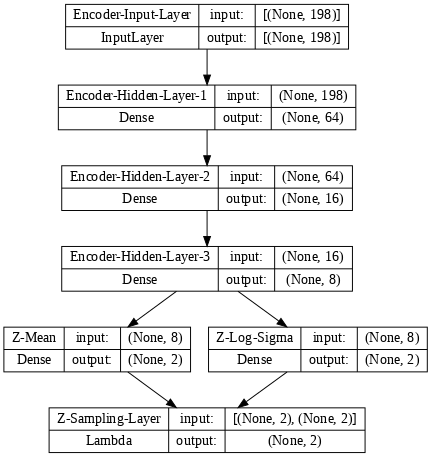

In [252]:
plot_model(encoder, show_shapes=True, dpi=70)

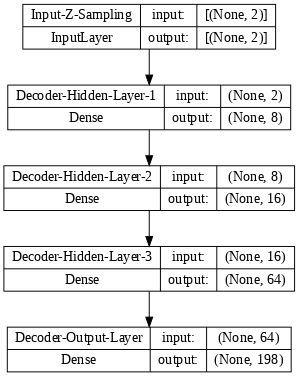

In [253]:
plot_model(decoder, show_shapes=True, dpi=70)

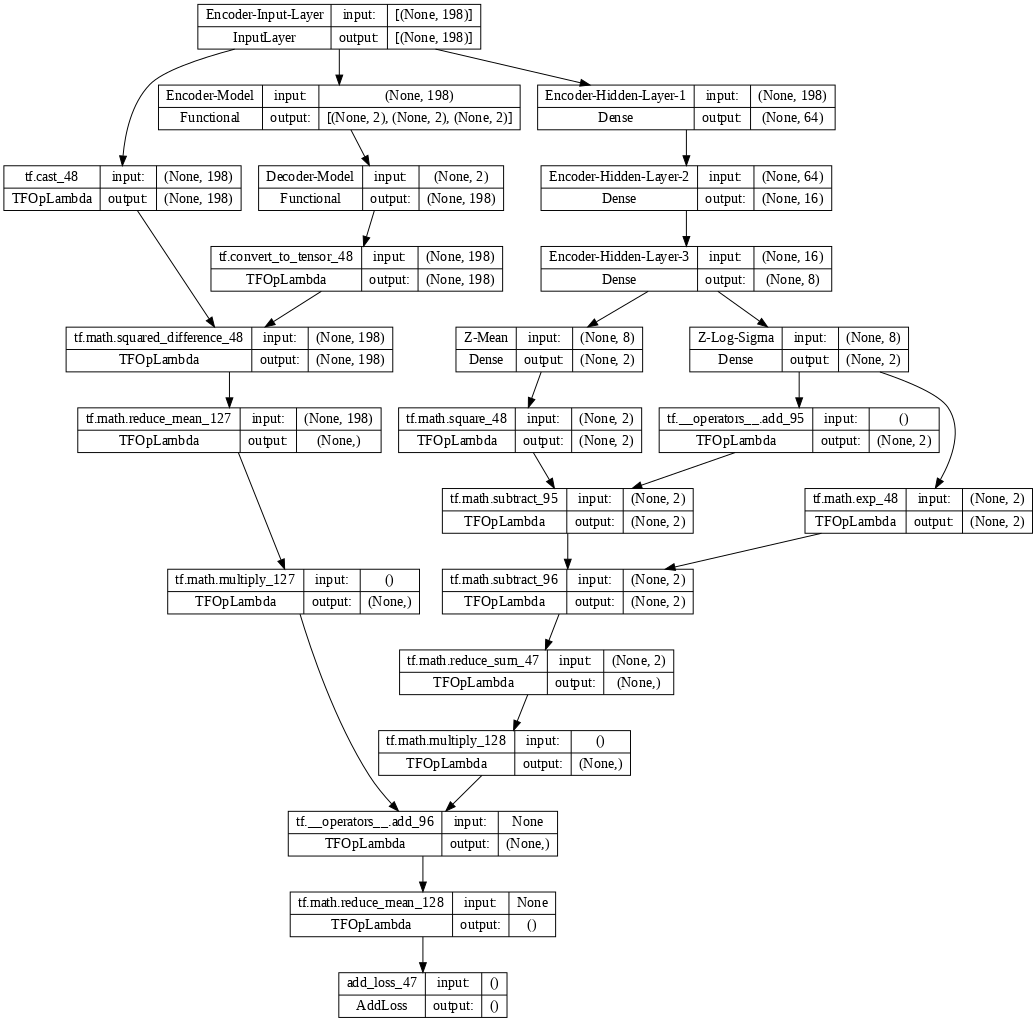

In [254]:
plot_model(vae, show_shapes=True, dpi=70)

## Experiment 1: Training on all routes

### Data

In [19]:
N_SAMPLES = 25099
samples = draw_samples(mb_2016, N_SAMPLES)

X = np.array(get_matrices(samples, ['start', 'mid', 'end'])[1])
y = np.array([samples[x]['grade'] for x in samples])

print('X shape:', X.shape)
print('y shape:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# flatten data

X_train_flat = X_train.reshape(len(X_train), 198)
X_test_flat = X_test.reshape(len(X_test), 198)

# Print shapes
print("New shape of X_train: ", X_train_flat.shape)
print("New shape of X_test: ", X_test_flat.shape)

X shape: (25099, 18, 11)
y shape: (25099,)
New shape of X_train:  (20079, 198)
New shape of X_test:  (5020, 198)


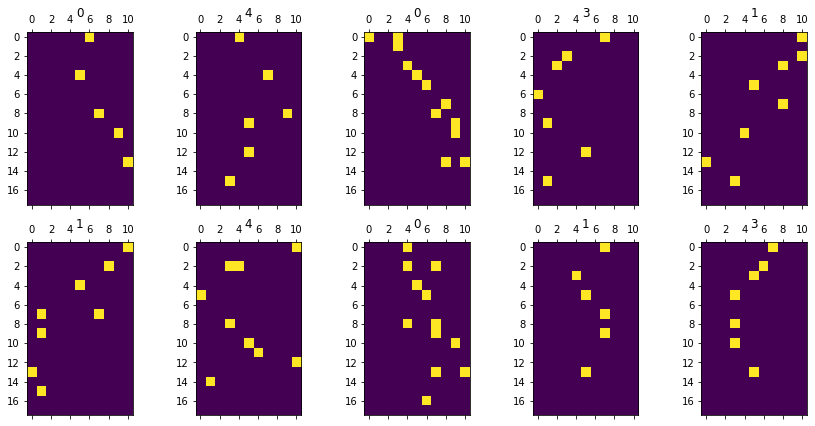

In [20]:
vis_train_data(X_train, y_train)

### Instantiating a model

In [24]:
encoder_flat, decoder_flat, vae_flat = vae_simple()

### Training

Epoch 1/15
1004/1004 [==============================] - 4s 4ms/step - loss: 8.8149 - val_loss: 6.9145
Epoch 2/15
1004/1004 [==============================] - 4s 4ms/step - loss: 6.9079 - val_loss: 6.8730
Epoch 3/15
1004/1004 [==============================] - 3s 3ms/step - loss: 6.8855 - val_loss: 6.8678
Epoch 4/15
1004/1004 [==============================] - 4s 4ms/step - loss: 6.8772 - val_loss: 6.8524
Epoch 5/15
1004/1004 [==============================] - 4s 4ms/step - loss: 6.8581 - val_loss: 6.8291
Epoch 6/15
1004/1004 [==============================] - 3s 3ms/step - loss: 6.8463 - val_loss: 6.8233
Epoch 7/15
1004/1004 [==============================] - 3s 3ms/step - loss: 6.8414 - val_loss: 6.8242
Epoch 8/15
1004/1004 [==============================] - 7s 7ms/step - loss: 6.8400 - val_loss: 6.8186
Epoch 9/15
1004/1004 [==============================] - 8s 8ms/step - loss: 6.8379 - val_loss: 6.8215
Epoch 10/15
1004/1004 [==============================] - 7s 7ms/step - loss: 6.836

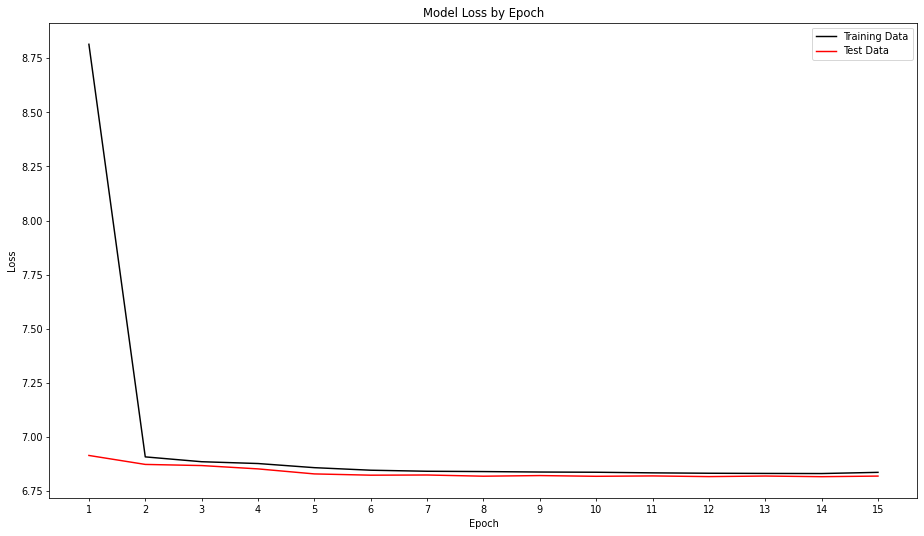

In [25]:
# Train VAE model
EPOCHS = 15
history = vae_flat.fit(X_train_flat, X_train_flat, epochs = EPOCHS, batch_size=20, validation_data=(X_test_flat, X_test_flat))

vis_history(history)

### Results

In [26]:
vis_latent_2(encoder_flat, X_train_flat, y_train)

628/628 [==============================] - 1s 2ms/step


Latent input: [0, 0]

Visualized output:


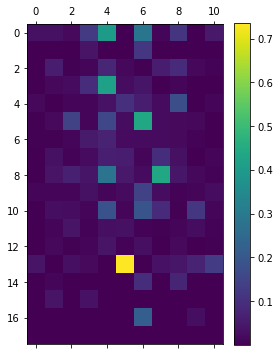


Filtered Routes Based on Number of Holds:


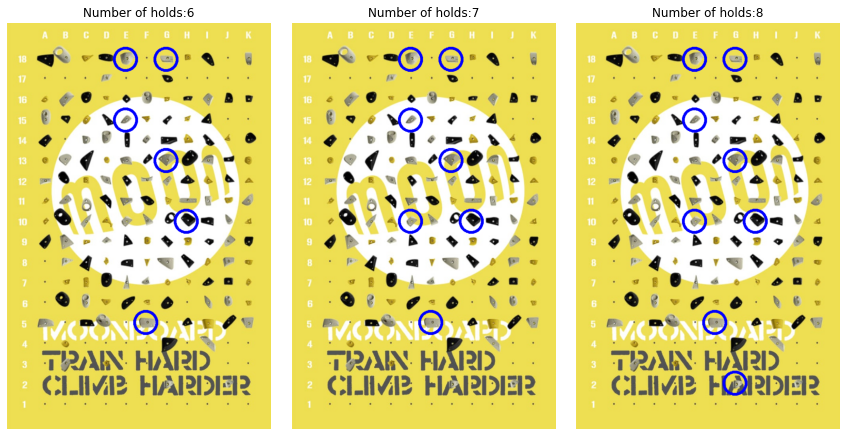

In [56]:
display_generated_route_flat([0,0], decoder_flat)

Latent input: [1, 1]

Visualized output:


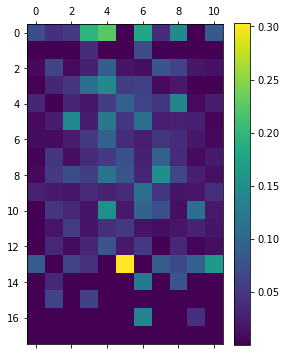


Filtered Routes Based on Number of Holds:


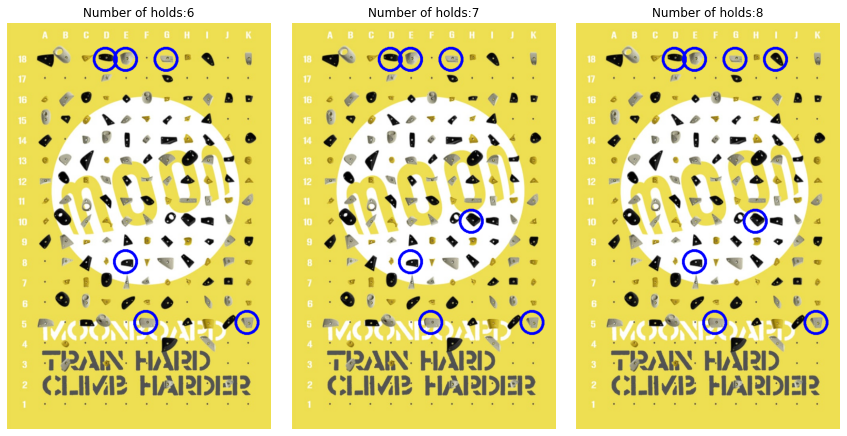

In [57]:
display_generated_route_flat([1,1], decoder_flat)

Latent input: [-1, -1]

Visualized output:


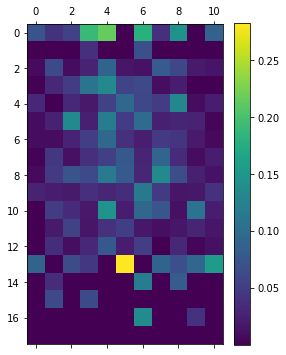


Filtered Routes Based on Number of Holds:


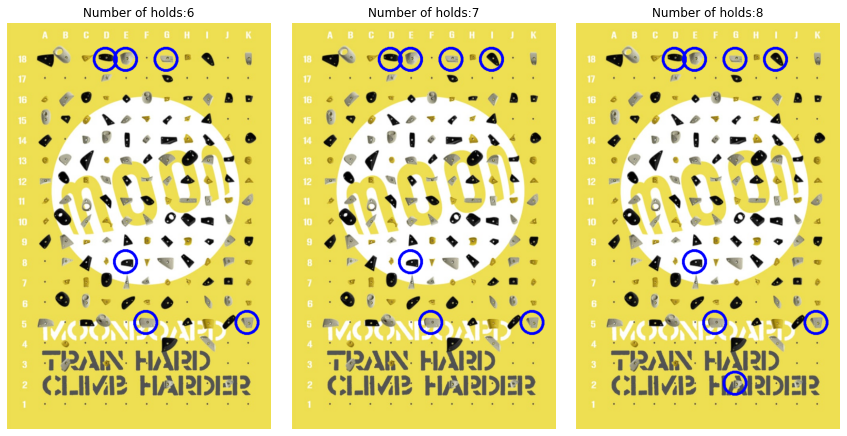

In [59]:
display_generated_route_flat([-1,-1], decoder_flat)

The flaw with this method is its overtendency to generate lots of finish holds. That is the motivation for us to use three channels to signal start, mid, and end holds.

## Experiment 2: Training on small samples

### Data

In [84]:
small_sample_size = 500
n_sets_samples = 3

small_samples = {}
for i in range(n_sets_samples):
  small_samples[i] = draw_samples(mb_2016, small_sample_size)

print('Number of sets:', n_sets_samples)
print('Number of samples in each set:', small_sample_size)

X_flat0 = np.array(get_matrices(small_samples[0], ['start', 'mid', 'end'])[1]).reshape(small_sample_size, 198)

X_flat1 = np.array(get_matrices(small_samples[1], ['start', 'mid', 'end'])[1]).reshape(small_sample_size, 198)

X_flat2 = np.array(get_matrices(small_samples[2], ['start', 'mid', 'end'])[1]).reshape(small_sample_size, 198)

X_train_flat0, X_test_flat0 = train_test_split(X_flat0, test_size=0.2)
X_train_flat1, X_test_flat1 = train_test_split(X_flat1, test_size=0.2)
X_train_flat2, X_test_flat2 = train_test_split(X_flat2, test_size=0.2)

Number of sets: 3
Number of samples in each set: 500


### Instantiating models

In [90]:
encoder_flat0, decoder_flat0, vae_flat0 = vae_simple()
encoder_flat1, decoder_flat1, vae_flat1 = vae_simple()
encoder_flat2, decoder_flat2, vae_flat2 = vae_simple()

Epoch 1/15
13/13 [==============================] - 1s 19ms/step - loss: 48.4557 - val_loss: 46.8075
Epoch 2/15
13/13 [==============================] - 0s 6ms/step - loss: 44.0538 - val_loss: 41.4215
Epoch 3/15
13/13 [==============================] - 0s 6ms/step - loss: 35.0652 - val_loss: 27.2412
Epoch 4/15
13/13 [==============================] - 0s 5ms/step - loss: 20.7766 - val_loss: 14.5352
Epoch 5/15
13/13 [==============================] - 0s 5ms/step - loss: 13.9727 - val_loss: 12.7457
Epoch 6/15
13/13 [==============================] - 0s 5ms/step - loss: 11.0711 - val_loss: 9.6738
Epoch 7/15
13/13 [==============================] - 0s 5ms/step - loss: 9.8334 - val_loss: 8.8787
Epoch 8/15
13/13 [==============================] - 0s 6ms/step - loss: 8.9240 - val_loss: 8.6431
Epoch 9/15
13/13 [==============================] - 0s 5ms/step - loss: 8.1349 - val_loss: 8.1017
Epoch 10/15
13/13 [==============================] - 0s 5ms/step - loss: 7.8041 - val_loss: 7.8419
Epoch 1

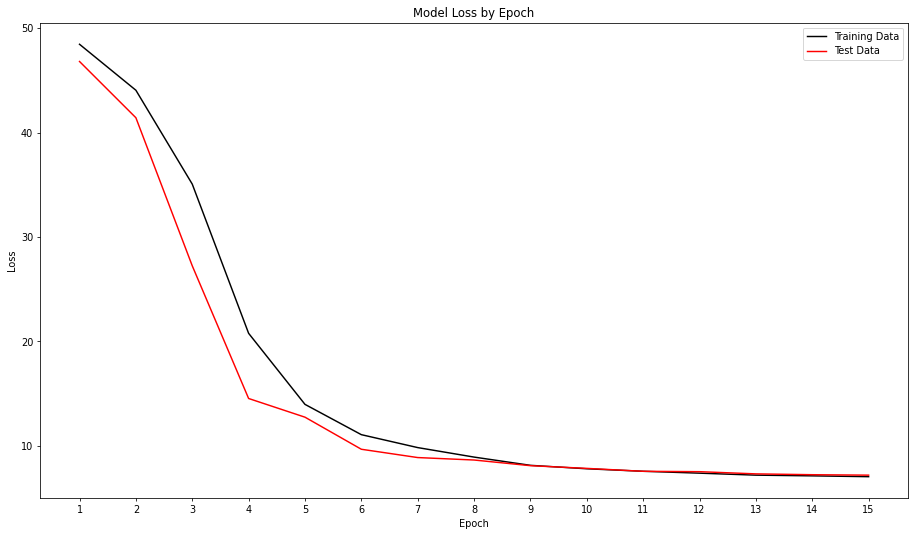

In [91]:
EPOCHS = 15
history = vae_flat0.fit(X_train_flat0, X_train_flat0, epochs = EPOCHS, validation_data=(X_test_flat0, X_test_flat0))

vis_history(history)

Epoch 1/15
13/13 [==============================] - 2s 36ms/step - loss: 47.9497 - val_loss: 45.8244
Epoch 2/15
13/13 [==============================] - 0s 11ms/step - loss: 43.1135 - val_loss: 38.3206
Epoch 3/15
13/13 [==============================] - 0s 13ms/step - loss: 34.1977 - val_loss: 26.2822
Epoch 4/15
13/13 [==============================] - 0s 12ms/step - loss: 20.3334 - val_loss: 13.7341
Epoch 5/15
13/13 [==============================] - 0s 6ms/step - loss: 12.1514 - val_loss: 10.6609
Epoch 6/15
13/13 [==============================] - 0s 6ms/step - loss: 10.0683 - val_loss: 9.6515
Epoch 7/15
13/13 [==============================] - 0s 5ms/step - loss: 9.1557 - val_loss: 9.0321
Epoch 8/15
13/13 [==============================] - 0s 5ms/step - loss: 8.5343 - val_loss: 8.8261
Epoch 9/15
13/13 [==============================] - 0s 6ms/step - loss: 8.1382 - val_loss: 8.0342
Epoch 10/15
13/13 [==============================] - 0s 6ms/step - loss: 7.8081 - val_loss: 7.9145
Epoc

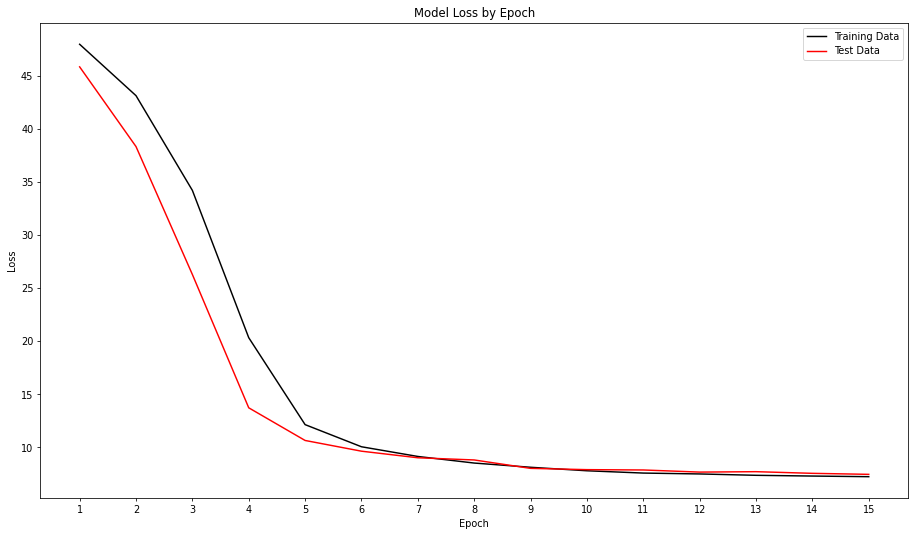

In [92]:
EPOCHS = 15
history = vae_flat1.fit(X_train_flat1, X_train_flat1, epochs = EPOCHS, validation_data=(X_test_flat1, X_test_flat1))

vis_history(history)

Epoch 1/15
13/13 [==============================] - 2s 22ms/step - loss: 47.5899 - val_loss: 44.6521
Epoch 2/15
13/13 [==============================] - 0s 7ms/step - loss: 40.0256 - val_loss: 32.6599
Epoch 3/15
13/13 [==============================] - 0s 6ms/step - loss: 25.7789 - val_loss: 17.5267
Epoch 4/15
13/13 [==============================] - 0s 6ms/step - loss: 14.6664 - val_loss: 13.2054
Epoch 5/15
13/13 [==============================] - 0s 6ms/step - loss: 12.0425 - val_loss: 11.4499
Epoch 6/15
13/13 [==============================] - 0s 7ms/step - loss: 10.2929 - val_loss: 10.0810
Epoch 7/15
13/13 [==============================] - 0s 5ms/step - loss: 9.2095 - val_loss: 9.7862
Epoch 8/15
13/13 [==============================] - 0s 5ms/step - loss: 8.5845 - val_loss: 8.5562
Epoch 9/15
13/13 [==============================] - 0s 6ms/step - loss: 8.0471 - val_loss: 8.5994
Epoch 10/15
13/13 [==============================] - 0s 5ms/step - loss: 7.7302 - val_loss: 8.2095
Epoch 

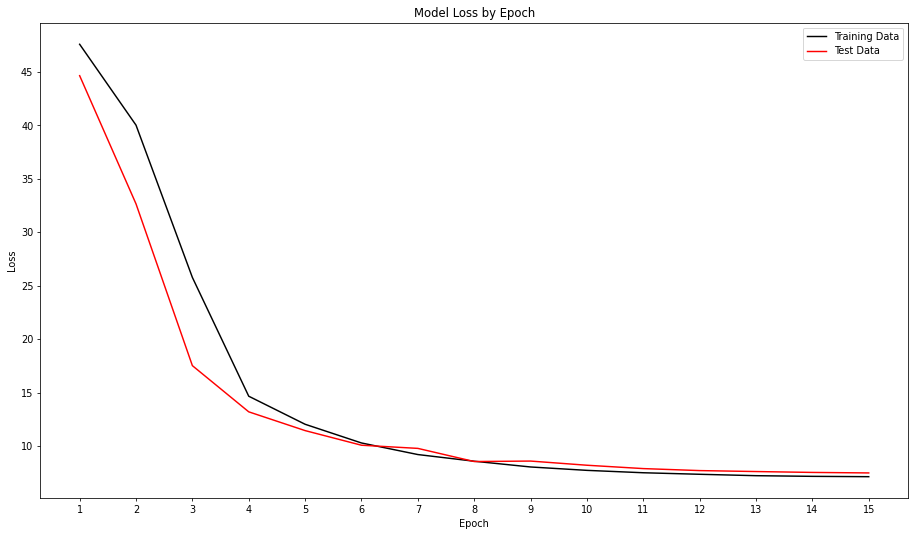

In [93]:
EPOCHS = 15
history = vae_flat2.fit(X_train_flat2, X_train_flat2, epochs = EPOCHS, validation_data=(X_test_flat2, X_test_flat2))

vis_history(history)

### Results
Testing the same input vector on 3 models. Each produces different outputs.

Latent input: [0, 0]

Visualized output:


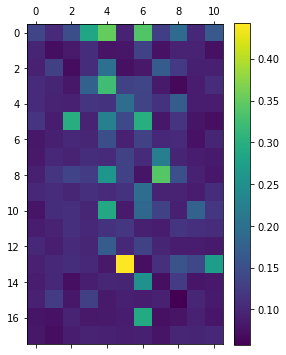


Filtered Routes Based on Number of Holds:


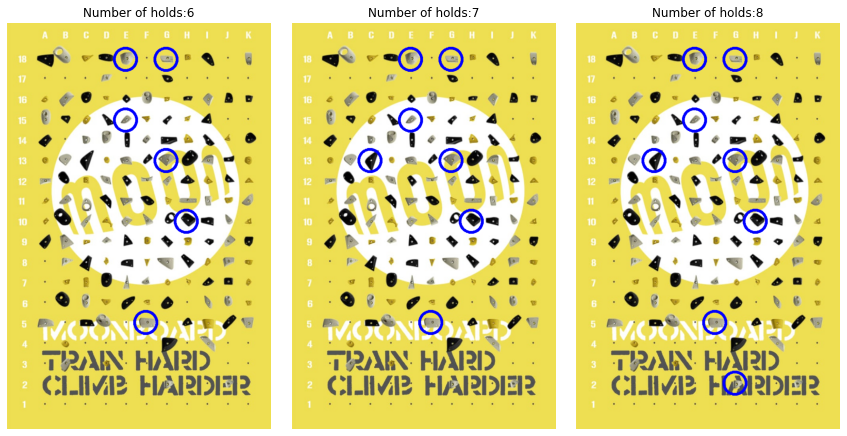

In [94]:
display_generated_route_flat([0,0], decoder_flat0)

Latent input: [0, 0]

Visualized output:


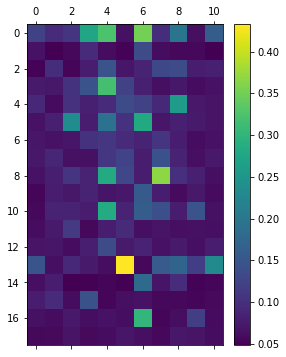


Filtered Routes Based on Number of Holds:


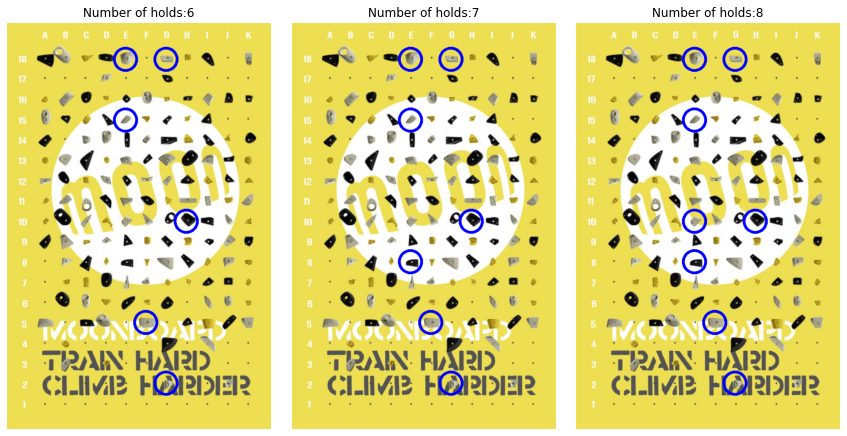

In [95]:
display_generated_route_flat([0,0], decoder_flat1)

Latent input: [0, 0]

Visualized output:


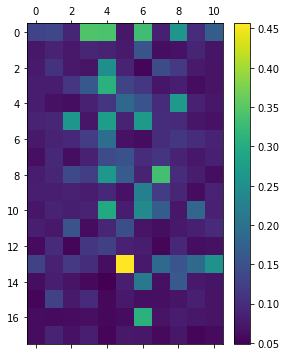


Filtered Routes Based on Number of Holds:


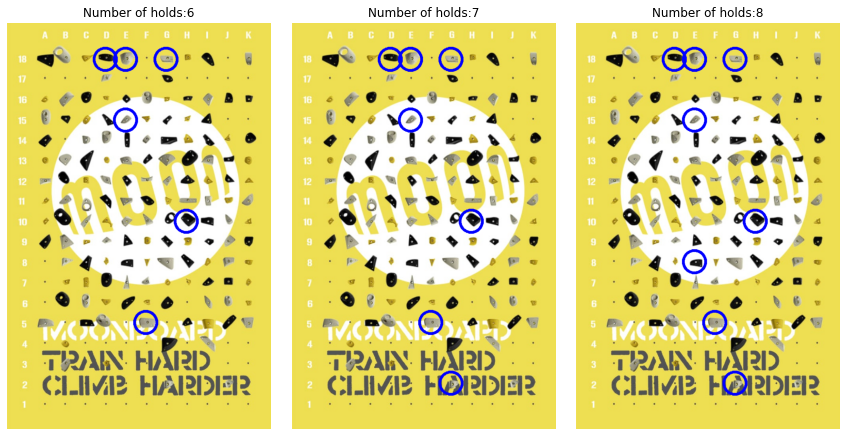

In [96]:
display_generated_route_flat([0,0], decoder_flat2)

# 3-Channel VAE

### Preparing the Model

In [255]:
channels_dim = 3 # one channel for start, mid, end respetively
original_dim = (18, 11, channels_dim) 
latent_dim = 2 # latent space dimension

In [256]:
# Reference for using 2DConv: https://github.com/pbr142/vae/blob/main/VAE_CIFAR10.ipynb

def vae_3_channels():
  #--- Input Layer
  visible = keras.Input(shape=original_dim, name='Encoder-Input-Layer')

  #--- Hidden Layers
  h_enc1 = Flatten()(visible)
  h_enc2 = Dense(units=32, activation='relu', name='Encoder-Hidden-Layer-1')(h_enc1)
  h_enc3 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc2)
  h_enc4 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc3)

  # h_enc3 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc2)
  # h_enc4 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc3)
  # h_enc5 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-4')(h_enc4)

  #--- Custom Latent Space Layer
  z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc4) # Mean component
  z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc4) # Standard deviation component
  z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

  # ********** Create Decoder **********

  #--- Input Layer 
  latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

  #--- Hidden Layer
  h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
  h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
  h_dec3 = Dense(units=32, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)
  # h_dec4 = Dense(units=128, activation='relu', name='Decoder-Hidden-Layer-4')(h_dec3)

  #--- Output Layer
  outputs = Dense(units = 594, activation='relu', name='Decoder-Output-Layer')(h_dec3)
  outputs = Reshape(original_dim)(outputs)

  #--- Create Encoder model
  encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

  #--- Create Decoder model
  decoder = Model(latent_inputs, outputs, name='Decoder-Model')

  # Define outputs from a VAE model by specifying how the encoder-decoder models are linked
  outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]

  r_loss = K.mean(keras.losses.mse(visible, outpt), axis=(1,2)) * 18 * 11
  kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
  vae_loss = K.mean(r_loss + kl_loss)

  vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

  return encoder, decoder, vae

In [257]:
encoder, decoder, vae = vae_3_channels()

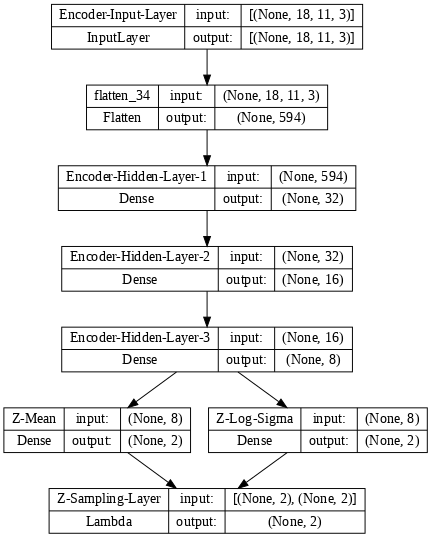

In [258]:
plot_model(encoder, show_shapes=True, dpi=70)

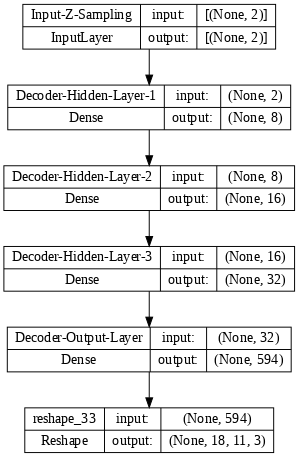

In [259]:
plot_model(decoder, show_shapes=True, dpi=70)

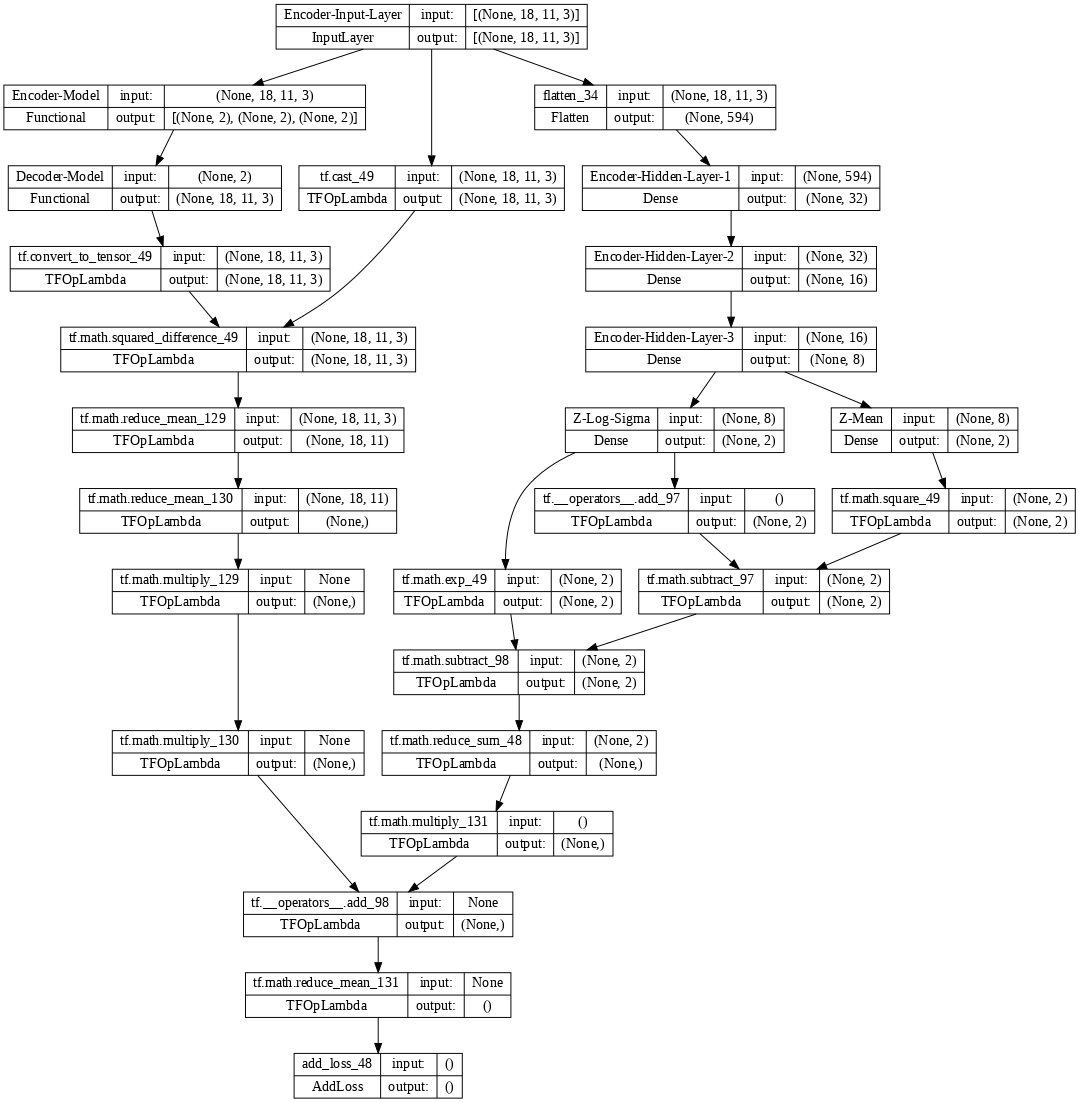

In [260]:
plot_model(vae, show_shapes=True, dpi=70)

## Experiment 1: Training on all routes, latent_dim = 2

### Data

In [101]:
N_SAMPLES = 25099
samples = draw_samples(mb_2016, N_SAMPLES)
print('Number of total samples:', N_SAMPLES)

X, y = get_X_y(samples)

print('X shape:', X.shape)
print('y shape:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Number of total samples: 25099
X shape: (25099, 18, 11, 3)
y shape: (25099,)
Shape of X_train:  (20079, 18, 11, 3)
Shape of X_test:  (5020, 18, 11, 3)


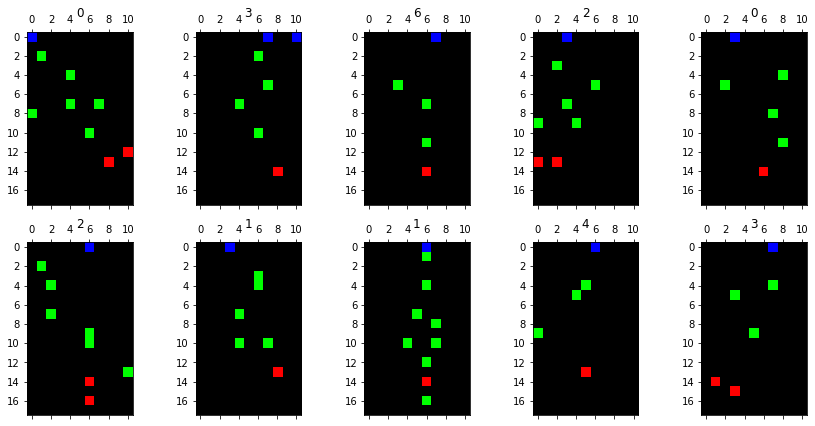

In [121]:
vis_train_data(X_train, y_train)

### Instantiating a model

In [110]:
encoder_all, decoder_all, vae_all = vae_3_channels()

### Training

Epoch 1/25
402/402 [==============================] - 3s 5ms/step - loss: 2.3429 - val_loss: 2.3215
Epoch 2/25
402/402 [==============================] - 2s 4ms/step - loss: 2.3236 - val_loss: 2.3208
Epoch 3/25
402/402 [==============================] - 2s 4ms/step - loss: 2.3231 - val_loss: 2.3208
Epoch 4/25
402/402 [==============================] - 2s 5ms/step - loss: 2.3231 - val_loss: 2.3207
Epoch 5/25
402/402 [==============================] - 2s 4ms/step - loss: 2.3222 - val_loss: 2.3158
Epoch 6/25
402/402 [==============================] - 2s 5ms/step - loss: 2.3175 - val_loss: 2.3163
Epoch 7/25
402/402 [==============================] - 2s 5ms/step - loss: 2.3174 - val_loss: 2.3156
Epoch 8/25
402/402 [==============================] - 2s 5ms/step - loss: 2.3175 - val_loss: 2.3157
Epoch 9/25
402/402 [==============================] - 2s 4ms/step - loss: 2.3172 - val_loss: 2.3158
Epoch 10/25
402/402 [==============================] - 2s 4ms/step - loss: 2.3173 - val_loss: 2.3158

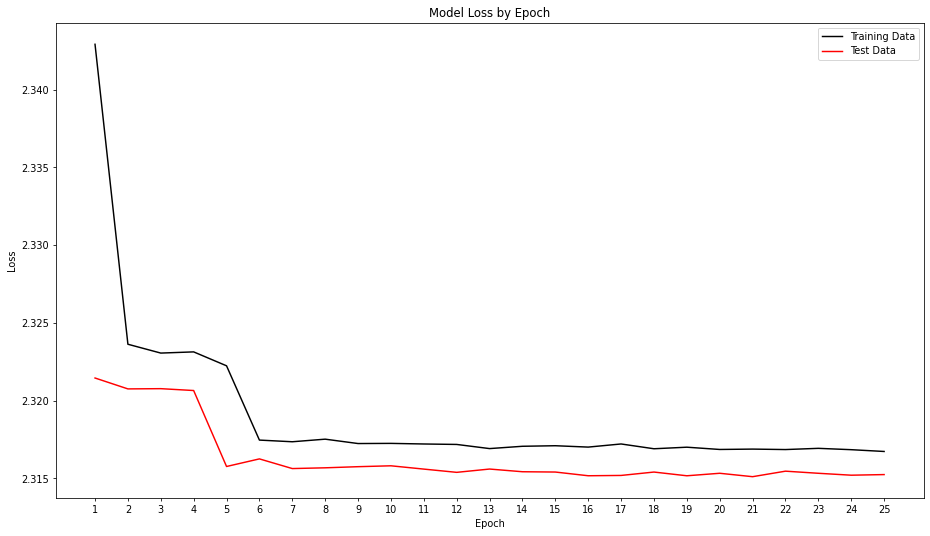

In [111]:
# Train VAE model
EPOCHS = 25
history = vae_all.fit(X_train, X_train, epochs = EPOCHS, batch_size = 50, validation_data=(X_test, X_test))

vis_history(history)

### Results: all outputs look the same

Latent input: [0, 0]

Visualized output:


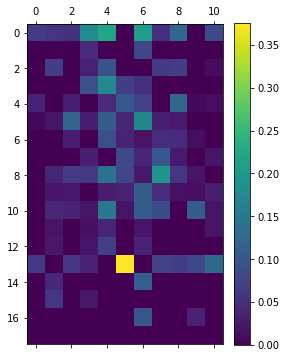


Filtered Routes Based on Number of Holds:


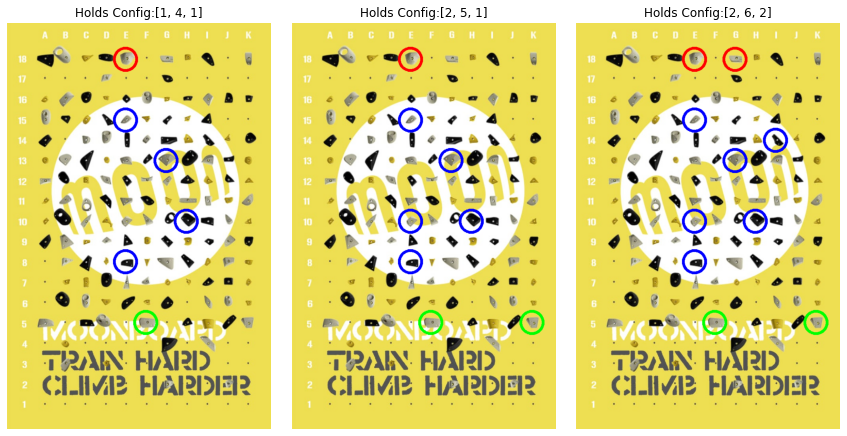

In [112]:
display_generated_route([0,0], decoder_all)

Latent input: [2.2, 1]

Visualized output:


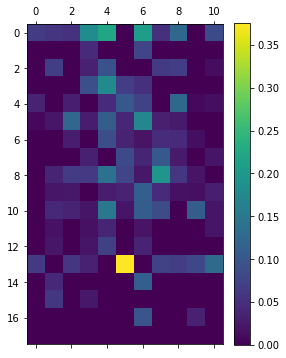


Filtered Routes Based on Number of Holds:


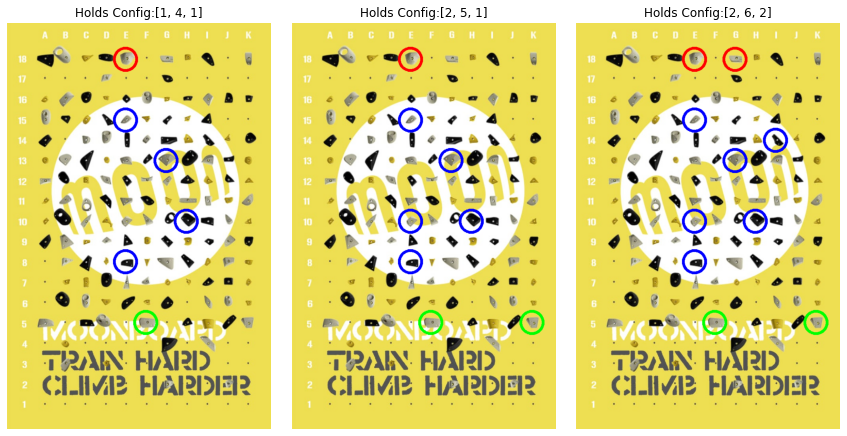

In [114]:
display_generated_route([2.2, 1], decoder_all)

Latent input: [5, 5]

Visualized output:


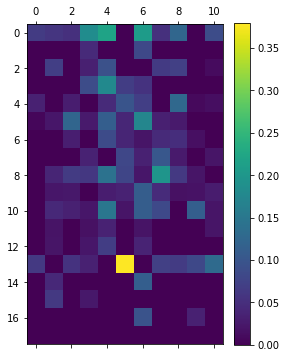


Filtered Routes Based on Number of Holds:


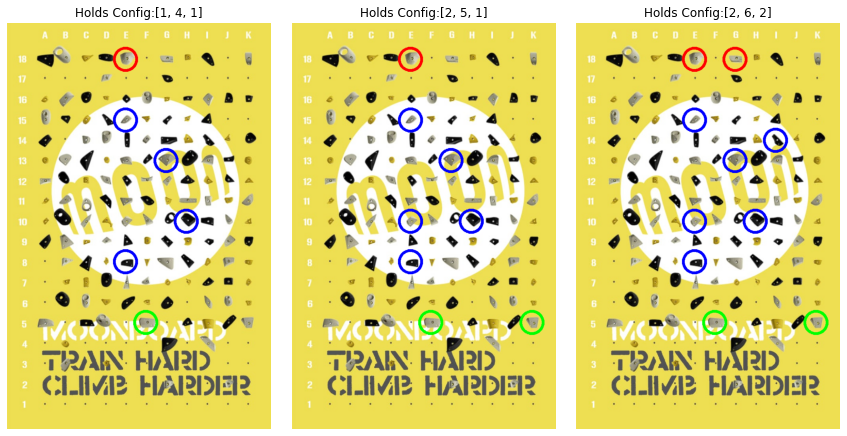

In [115]:
display_generated_route([5,5], decoder_all)

## Experiment 2: Training on each grade level, latent_dim = 2

### Data

In [116]:
routes_0 = routes_by_grade[0]
routes_1 = routes_by_grade[1]
routes_2 = routes_by_grade[2]
routes_3 = routes_by_grade[3]
routes_4 = routes_by_grade[4]
routes_5 = routes_by_grade[5]
routes_6 = routes_by_grade[6]

Grade = 5

In [117]:
X5, y5 = get_X_y(routes_5)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2)

X5_train = X5_train.astype("float32")
X5_test = X5_test.astype("float32")

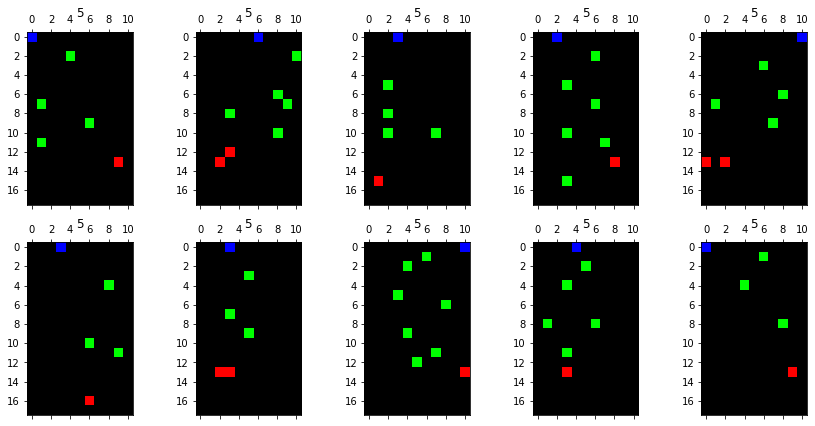

In [123]:
vis_train_data(X5_train, y5_train)

Grade = 6

In [124]:
X6, y6 = get_X_y(routes_6)

X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2)

X6_train = X6_train.astype("float32")
X6_test = X5_test.astype("float32")

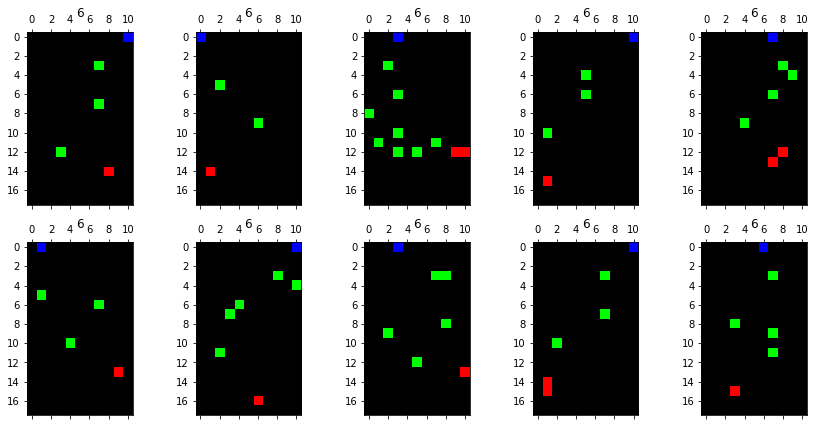

In [125]:
vis_train_data(X6_train, y6_train)

### Instantiating a model

In [130]:
encoder_5, decoder_5, vae_5 = vae_3_channels()

In [127]:
encoder_6, decoder_6, vae_6 = vae_3_channels()

### Training

Epoch 1/25
18/18 [==============================] - 2s 22ms/step - loss: 2.2726 - val_loss: 2.2258
Epoch 2/25
18/18 [==============================] - 0s 6ms/step - loss: 2.1783 - val_loss: 2.1986
Epoch 3/25
18/18 [==============================] - 0s 5ms/step - loss: 2.1514 - val_loss: 2.1797
Epoch 4/25
18/18 [==============================] - 0s 6ms/step - loss: 2.1378 - val_loss: 2.1696
Epoch 5/25
18/18 [==============================] - 0s 6ms/step - loss: 2.1330 - val_loss: 2.1653
Epoch 6/25
18/18 [==============================] - 0s 7ms/step - loss: 2.1280 - val_loss: 2.1650
Epoch 7/25
18/18 [==============================] - 0s 5ms/step - loss: 2.1275 - val_loss: 2.1652
Epoch 8/25
18/18 [==============================] - 0s 6ms/step - loss: 2.1234 - val_loss: 2.1616
Epoch 9/25
18/18 [==============================] - 0s 5ms/step - loss: 2.1252 - val_loss: 2.1584
Epoch 10/25
18/18 [==============================] - 0s 5ms/step - loss: 2.1251 - val_loss: 2.1586
Epoch 11/25
18/18 

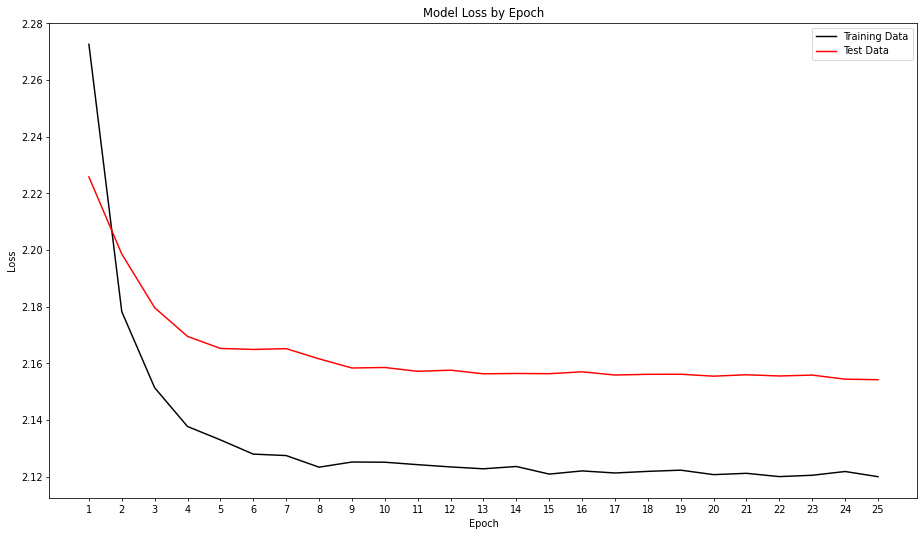

In [131]:
# grade = 5
EPOCHS = 25
history = vae_5.fit(X5_train, X5_train, epochs = EPOCHS, validation_data=(X5_test, X5_test))

# Plot a loss chart
vis_history(history)

Epoch 1/25
10/10 [==============================] - 2s 33ms/step - loss: 2.2749 - val_loss: 2.2701
Epoch 2/25
10/10 [==============================] - 0s 7ms/step - loss: 2.1598 - val_loss: 2.2417
Epoch 3/25
10/10 [==============================] - 0s 6ms/step - loss: 2.1309 - val_loss: 2.2155
Epoch 4/25
10/10 [==============================] - 0s 7ms/step - loss: 2.1087 - val_loss: 2.2007
Epoch 5/25
10/10 [==============================] - 0s 7ms/step - loss: 2.0867 - val_loss: 2.1926
Epoch 6/25
10/10 [==============================] - 0s 7ms/step - loss: 2.0889 - val_loss: 2.1843
Epoch 7/25
10/10 [==============================] - 0s 6ms/step - loss: 2.0816 - val_loss: 2.1847
Epoch 8/25
10/10 [==============================] - 0s 6ms/step - loss: 2.0818 - val_loss: 2.1788
Epoch 9/25
10/10 [==============================] - 0s 6ms/step - loss: 2.0609 - val_loss: 2.1784
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 2.0669 - val_loss: 2.1800
Epoch 11/25
10/10 

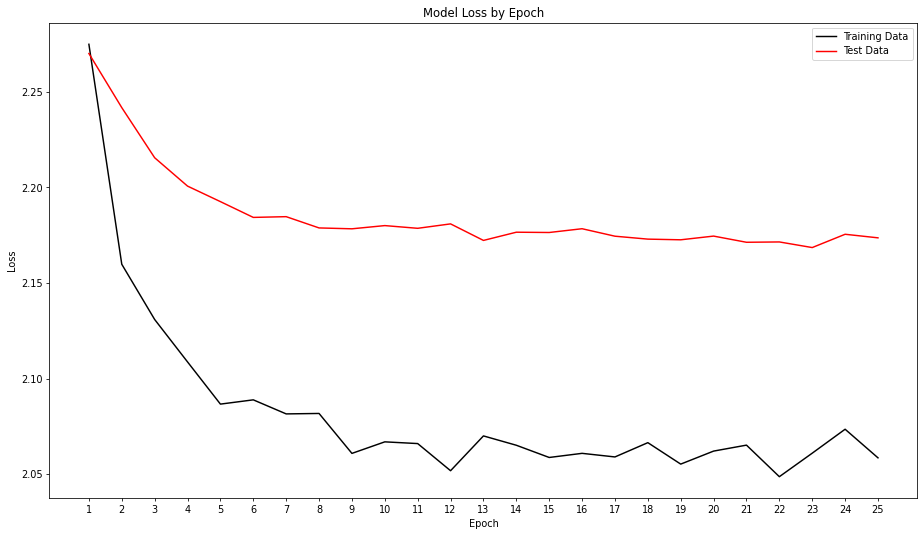

In [132]:
# grade = 6
EPOCHS = 25
history = vae_6.fit(X6_train, X6_train, epochs = EPOCHS, validation_data=(X6_test, X6_test))

# Plot a loss chart
vis_history(history)

### Results

Grade = 5
Latent input: [0, 0]

Visualized output:


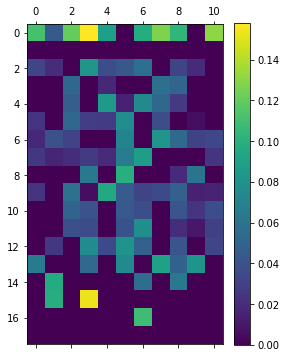


Filtered Routes Based on Number of Holds:


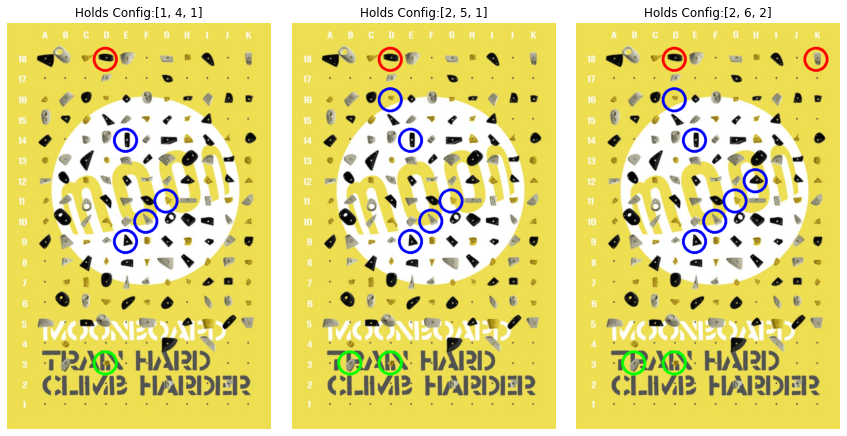

In [134]:
print('Grade = 5')
display_generated_route([0,0], decoder_5)

Grade = 5
Latent input: [-5, -5]

Visualized output:


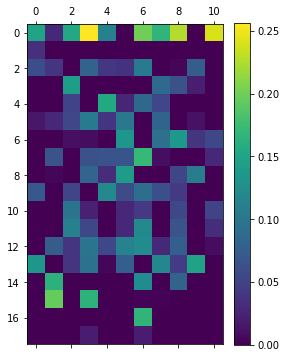


Filtered Routes Based on Number of Holds:


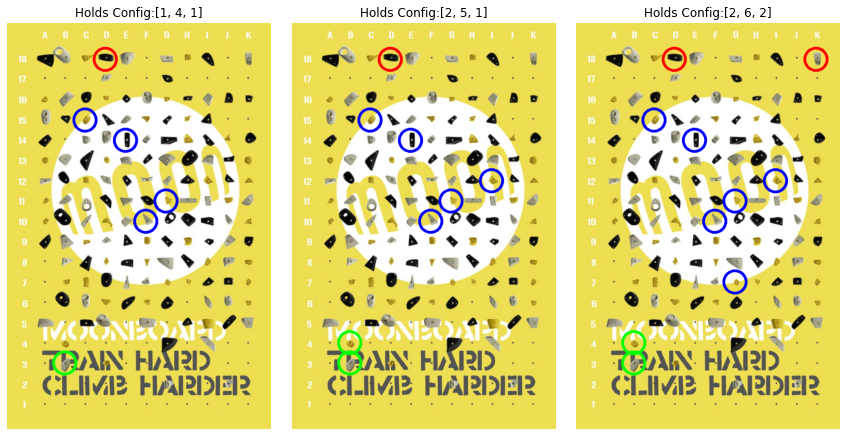

In [135]:
print('Grade = 5')
display_generated_route([-5,-5], decoder_5)

Grade = 6
Latent input: [1.5, 1]

Visualized output:


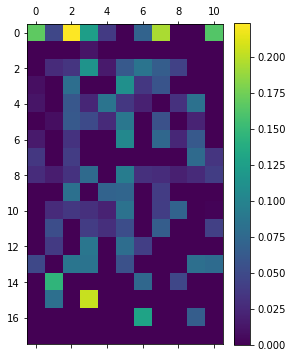


Filtered Routes Based on Number of Holds:


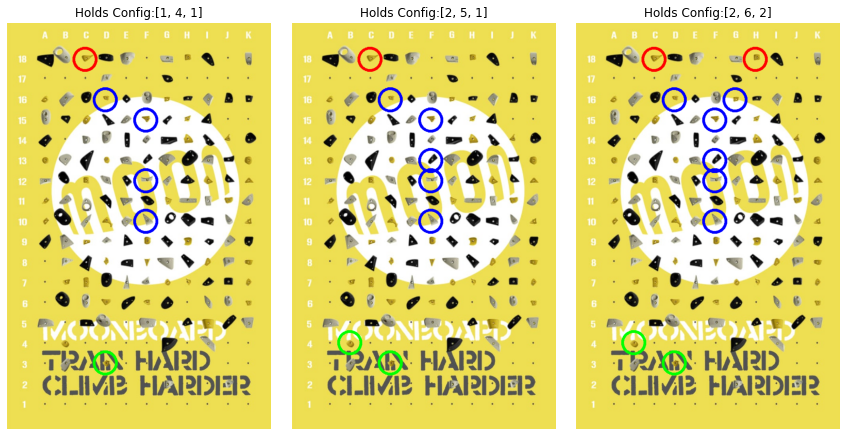

In [142]:
print('Grade = 6')
display_generated_route([1.5, 1], decoder_6)

Grade = 6
Latent input: [1, 0]

Visualized output:


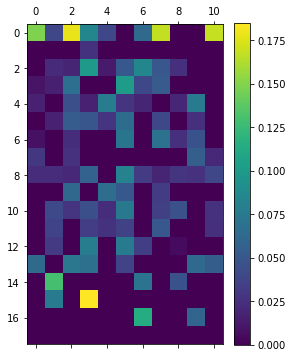


Filtered Routes Based on Number of Holds:


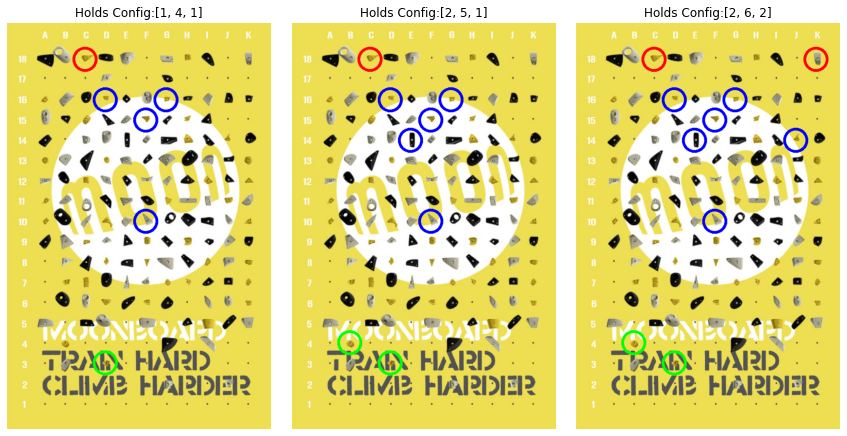

In [140]:
print('Grade = 6')
display_generated_route([1,0], decoder_6)

## Experiment 3: Training on small sample size, use each model to generate new routes

### Data

In [143]:
small_sample_size = 500
n_sets_samples = 4

small_samples = {}
for i in range(n_sets_samples):
  small_samples[i] = draw_samples(mb_2016, small_sample_size)

print('Number of sets:', n_sets_samples)
print('Number of samples in each set:', small_sample_size)

X_set0, y_set0 = get_X_y(small_samples[0])
X_set1, y_set1 = get_X_y(small_samples[1])
X_set2, y_set2 = get_X_y(small_samples[2])
X_set3, y_set3 = get_X_y(small_samples[3])

X_train_set0, X_test_set0, y_train_set0, y_test_set0 = train_test_split(X_set0, y_set0, test_size=0.2)
X_train_set1, X_test_set1, y_train_set1, y_test_set1 = train_test_split(X_set1, y_set1, test_size=0.2, random_state=22)
X_train_set2, X_test_set2, y_train_set2, y_test_set2 = train_test_split(X_set2, y_set2, test_size=0.2, random_state=22)
X_train_set3, X_test_set3, y_train_set3, y_test_set3 = train_test_split(X_set3, y_set3, test_size=0.2, random_state=22)

Number of sets: 4
Number of samples in each set: 500


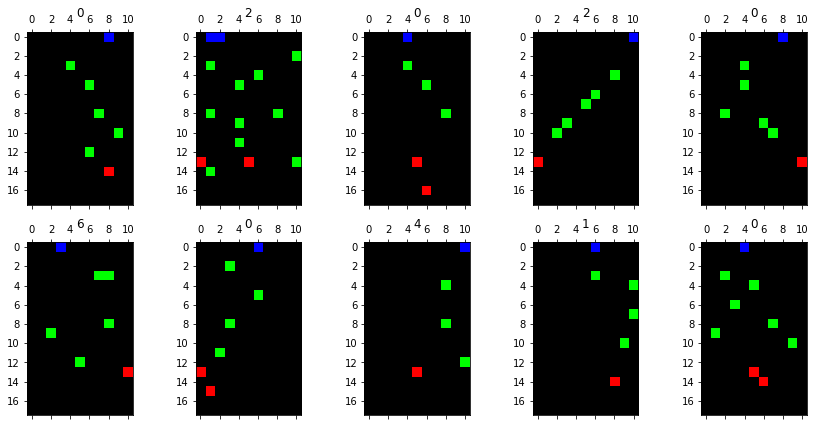

In [149]:
vis_train_data(X_train_set0, y_train_set0)

### Instantiating models

In [152]:
encoder0, decoder0, vae0 = vae_3_channels()
encoder1, decoder1, vae1 = vae_3_channels()
encoder2, decoder2, vae2 = vae_3_channels()
encoder3, decoder3, vae3 = vae_3_channels()

### Training

model 1

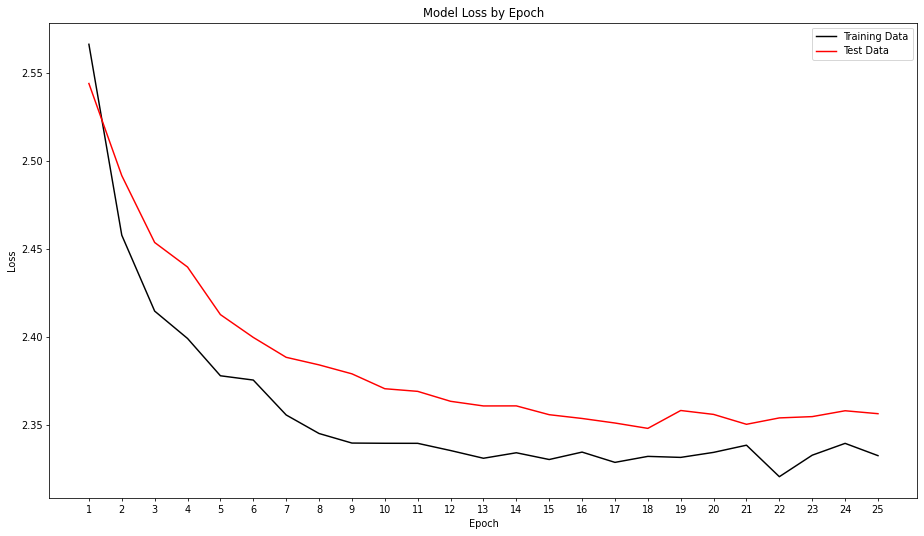

In [153]:
# set 0
EPOCHS = 25
history = vae0.fit(X_train_set0, X_train_set0, epochs = EPOCHS, validation_data=(X_test_set0, X_test_set0), verbose=False)

vis_history(history)

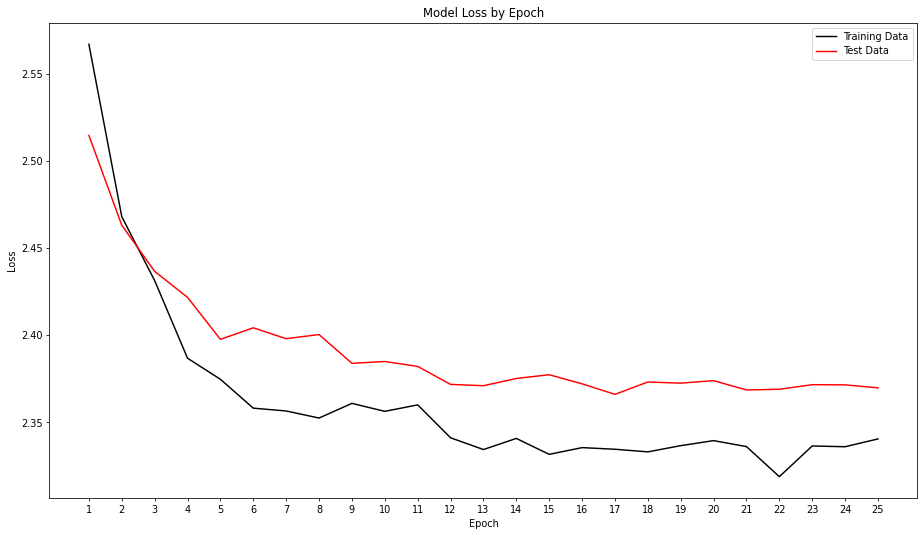

In [154]:
# set1
EPOCHS = 25
history = vae1.fit(X_train_set1, X_train_set1, epochs = EPOCHS, validation_data=(X_test_set1, X_test_set1), verbose=False)

vis_history(history)

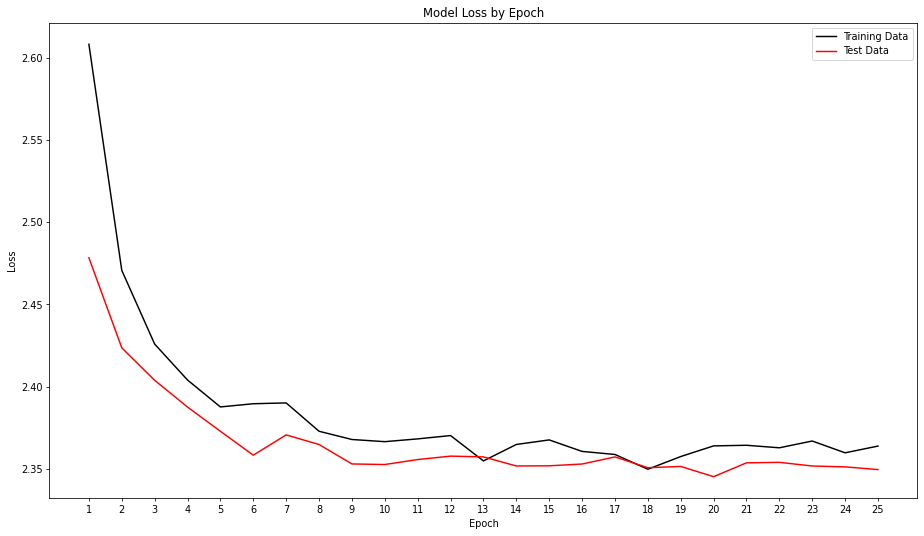

In [155]:
# set2
EPOCHS = 25
history = vae2.fit(X_train_set2, X_train_set2, epochs = EPOCHS, validation_data=(X_test_set2, X_test_set2), verbose=False)

vis_history(history)

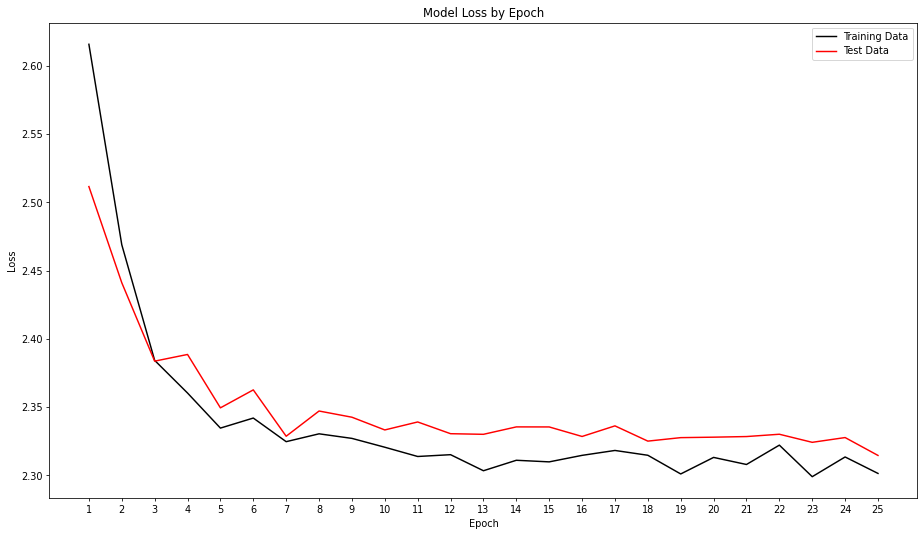

In [156]:
# set3
EPOCHS = 25
history = vae3.fit(X_train_set3, X_train_set3, epochs = EPOCHS, validation_data=(X_test_set3, X_test_set3), verbose=False)

vis_history(history)

### Results

Latent input: [0, 0]

Visualized output:


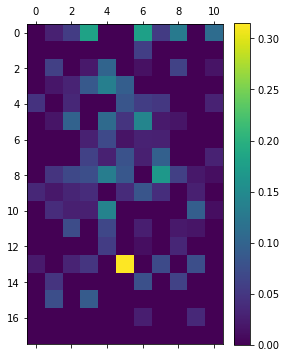


Filtered Routes Based on Number of Holds:


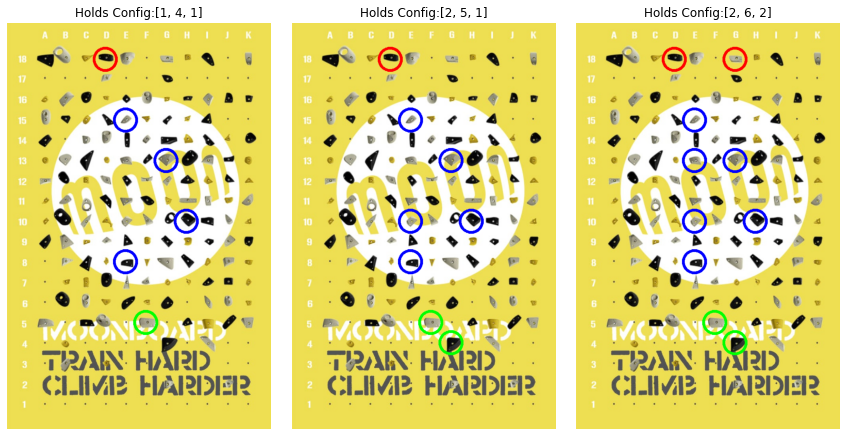

In [157]:
display_generated_route([0,0], decoder0)

Latent input: [0, 0]

Visualized output:


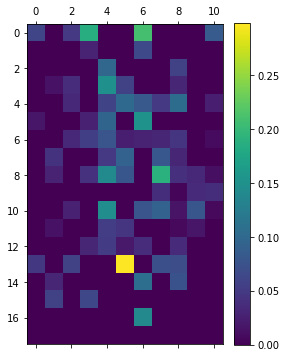


Filtered Routes Based on Number of Holds:


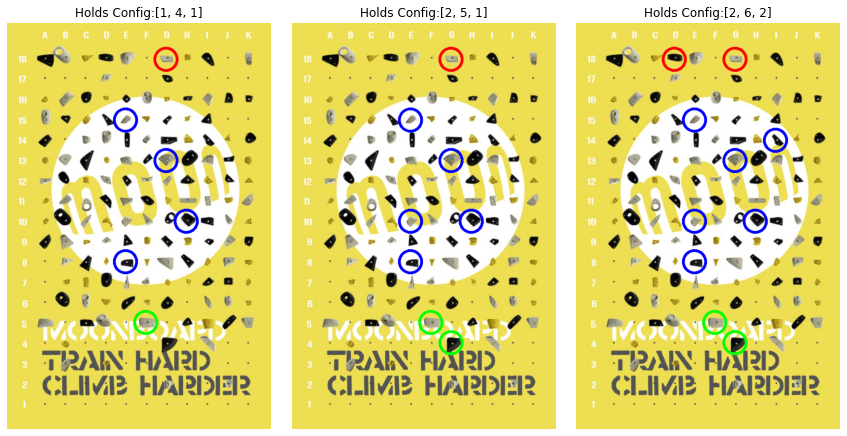

In [158]:
display_generated_route([0,0], decoder1)

Latent input: [0, 0]

Visualized output:


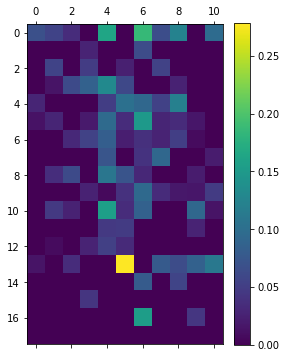


Filtered Routes Based on Number of Holds:


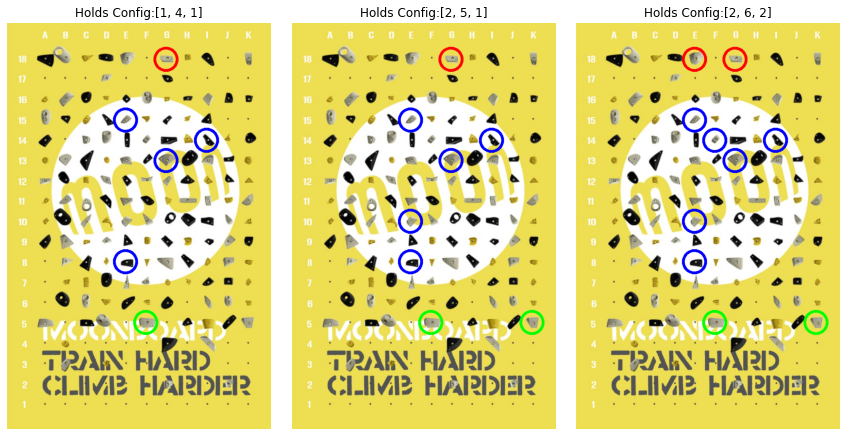

In [159]:
display_generated_route([0,0], decoder2)

Latent input: [0, 0]

Visualized output:


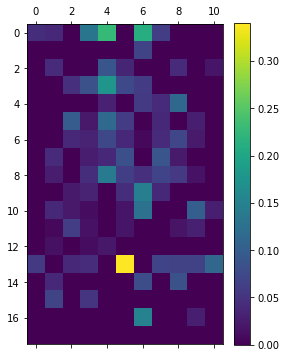


Filtered Routes Based on Number of Holds:


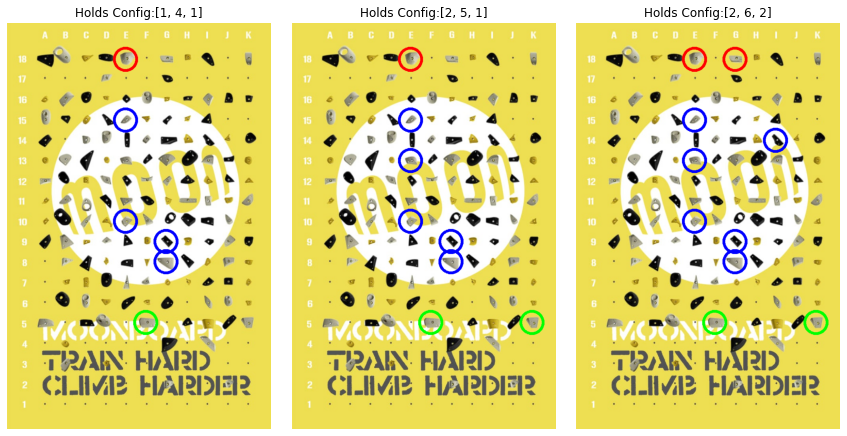

In [161]:
display_generated_route([0,0], decoder3)

Latent input: [-2, -2]

Visualized output:


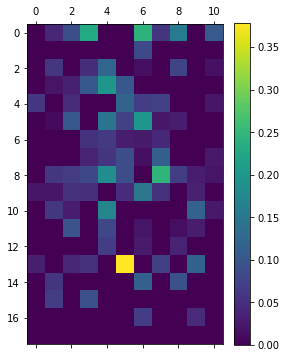


Filtered Routes Based on Number of Holds:


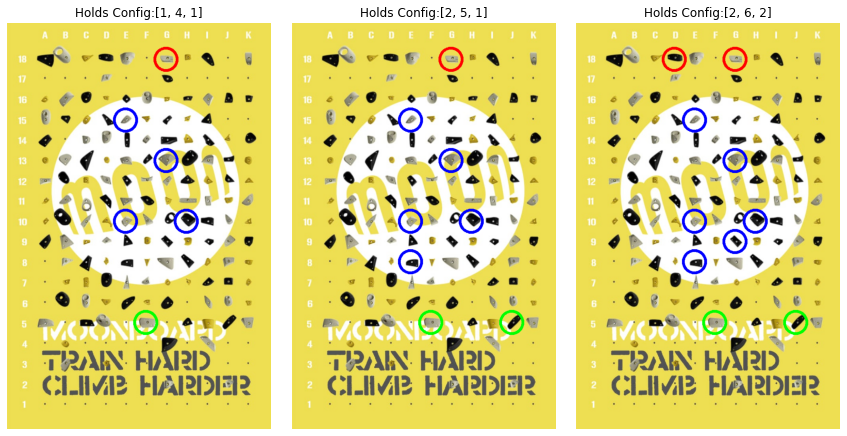

In [162]:
display_generated_route([-2,-2], decoder0)

Latent input: [-2, -2]

Visualized output:


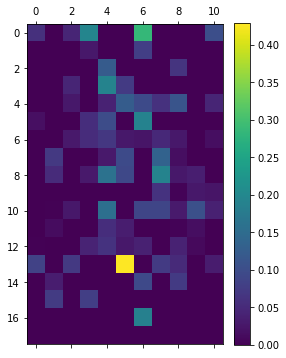


Filtered Routes Based on Number of Holds:


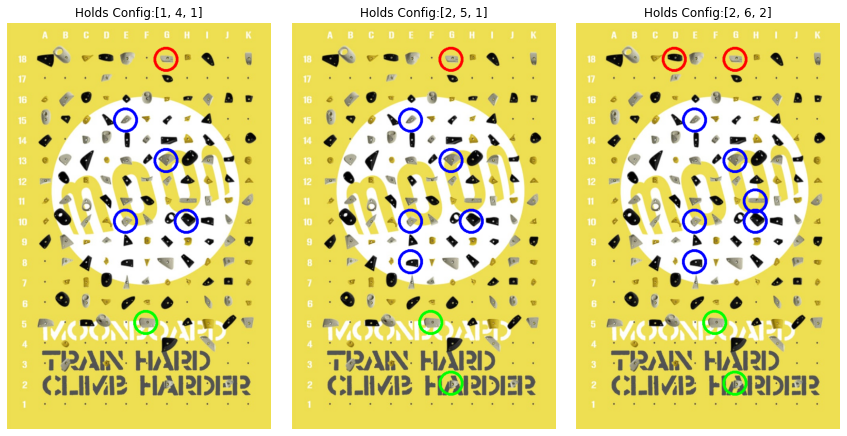

In [163]:
display_generated_route([-2,-2], decoder1)

Latent input: [-2, -2]

Visualized output:


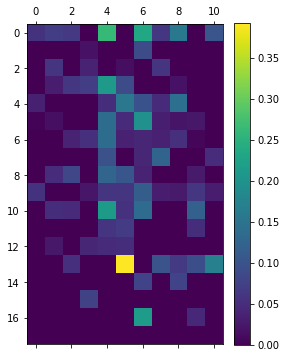


Filtered Routes Based on Number of Holds:


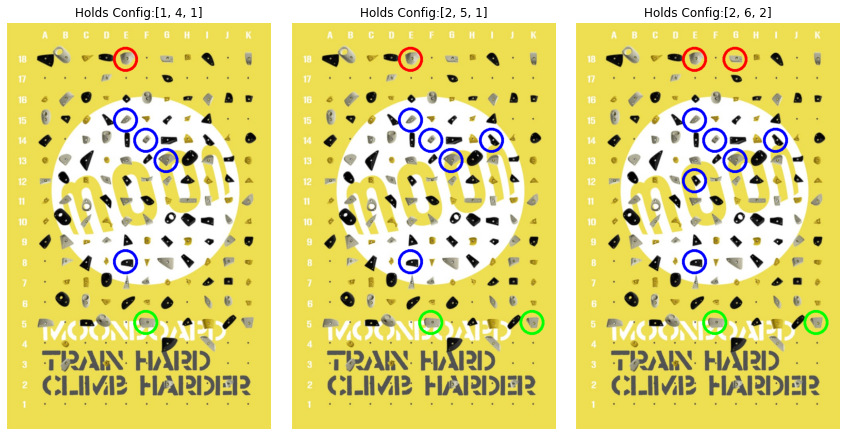

In [164]:
display_generated_route([-2,-2], decoder2)

Latent input: [-2, -2]

Visualized output:


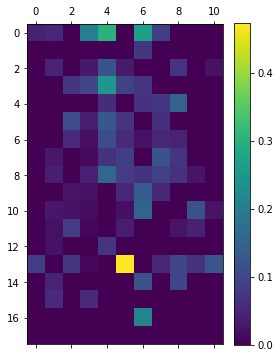


Filtered Routes Based on Number of Holds:


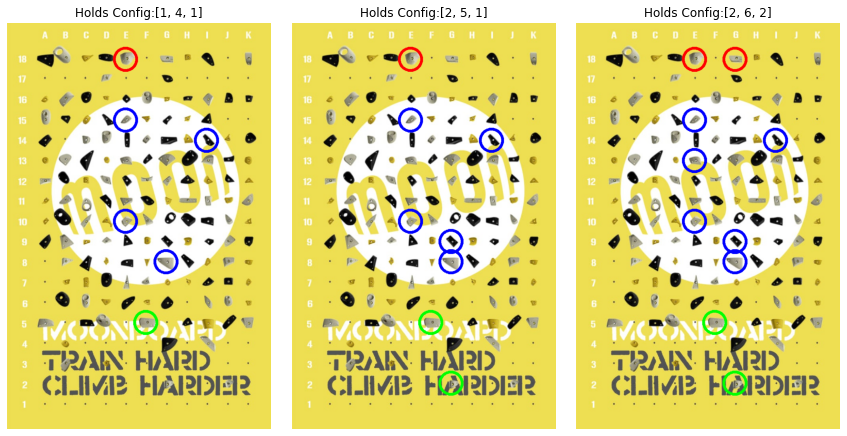

In [165]:
display_generated_route([-2,-2], decoder3)

Small Sample Training by Grade

# FINAL: Small Sample Training by Grade

### Data


sample size = 500, except for grade = 6

In [304]:
n_sample = 500

In [305]:
X0, _ = get_X_y(routes_0)
X0 = np.array(random.sample(list(X0), n_sample))
X0_train, X0_test = train_test_split(X0, test_size=0.2)

In [306]:
X1, _ = get_X_y(routes_1)
X1 = np.array(random.sample(list(X1), n_sample))
X1_train, X1_test = train_test_split(X1, test_size=0.2)

In [307]:
X2, _ = get_X_y(routes_2)
X2 = np.array(random.sample(list(X2), n_sample))
X2_train, X2_test = train_test_split(X2, test_size=0.2)

In [308]:
X3, _ = get_X_y(routes_3)
X3 = np.array(random.sample(list(X3), n_sample))
X3_train, X3_test = train_test_split(X3, test_size=0.2)

In [309]:
X4, _ = get_X_y(routes_4)
X4 = np.array(random.sample(list(X4), n_sample))
X4_train, X4_test = train_test_split(X4, test_size=0.2)

In [310]:
X5, _ = get_X_y(routes_5)
X5 = np.array(random.sample(list(X5), n_sample))
X5_train, X5_test = train_test_split(X5, test_size=0.2)

In [311]:
# total grade = 6 size smaller than 500
X6, y6 = get_X_y(routes_6)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2)

## LATENT_DIM = 2

In [312]:
latent_dim = 2

### Instantiating Models

In [313]:
encoder_f_0, decoder_f_0, vae_f_0 = vae_3_channels()
encoder_f_1, decoder_f_1, vae_f_1 = vae_3_channels()
encoder_f_2, decoder_f_2, vae_f_2 = vae_3_channels()
encoder_f_3, decoder_f_3, vae_f_3 = vae_3_channels()
encoder_f_4, decoder_f_4, vae_f_4 = vae_3_channels()
encoder_f_5, decoder_f_5, vae_f_5 = vae_3_channels()
encoder_f_6, decoder_f_6, vae_f_6 = vae_3_channels()

### Training

In [314]:
EPOCHS = 25
vae_f_0.fit(X0_train, X0_train, epochs = EPOCHS, validation_data=(X0_test, X0_test), verbose = False)
vae_f_1.fit(X1_train, X1_train, epochs = EPOCHS, validation_data=(X1_test, X1_test), verbose = False)
vae_f_2.fit(X2_train, X2_train, epochs = EPOCHS, validation_data=(X2_test, X2_test), verbose = False)
vae_f_3.fit(X3_train, X3_train, epochs = EPOCHS, validation_data=(X3_test, X3_test), verbose = False)
vae_f_4.fit(X4_train, X4_train, epochs = EPOCHS, validation_data=(X4_test, X4_test), verbose = False)
vae_f_5.fit(X5_train, X5_train, epochs = EPOCHS, validation_data=(X5_test, X5_test), verbose = False)
vae_f_6.fit(X6_train, X6_train, epochs = EPOCHS, validation_data=(X6_test, X6_test), verbose = False)

### Results

In [315]:
N_SETS = 7
N_TESTS = 5

all_latent_inputs = [[random.uniform(-4,4) for i in range(latent_dim)] for i in range(N_TESTS)]

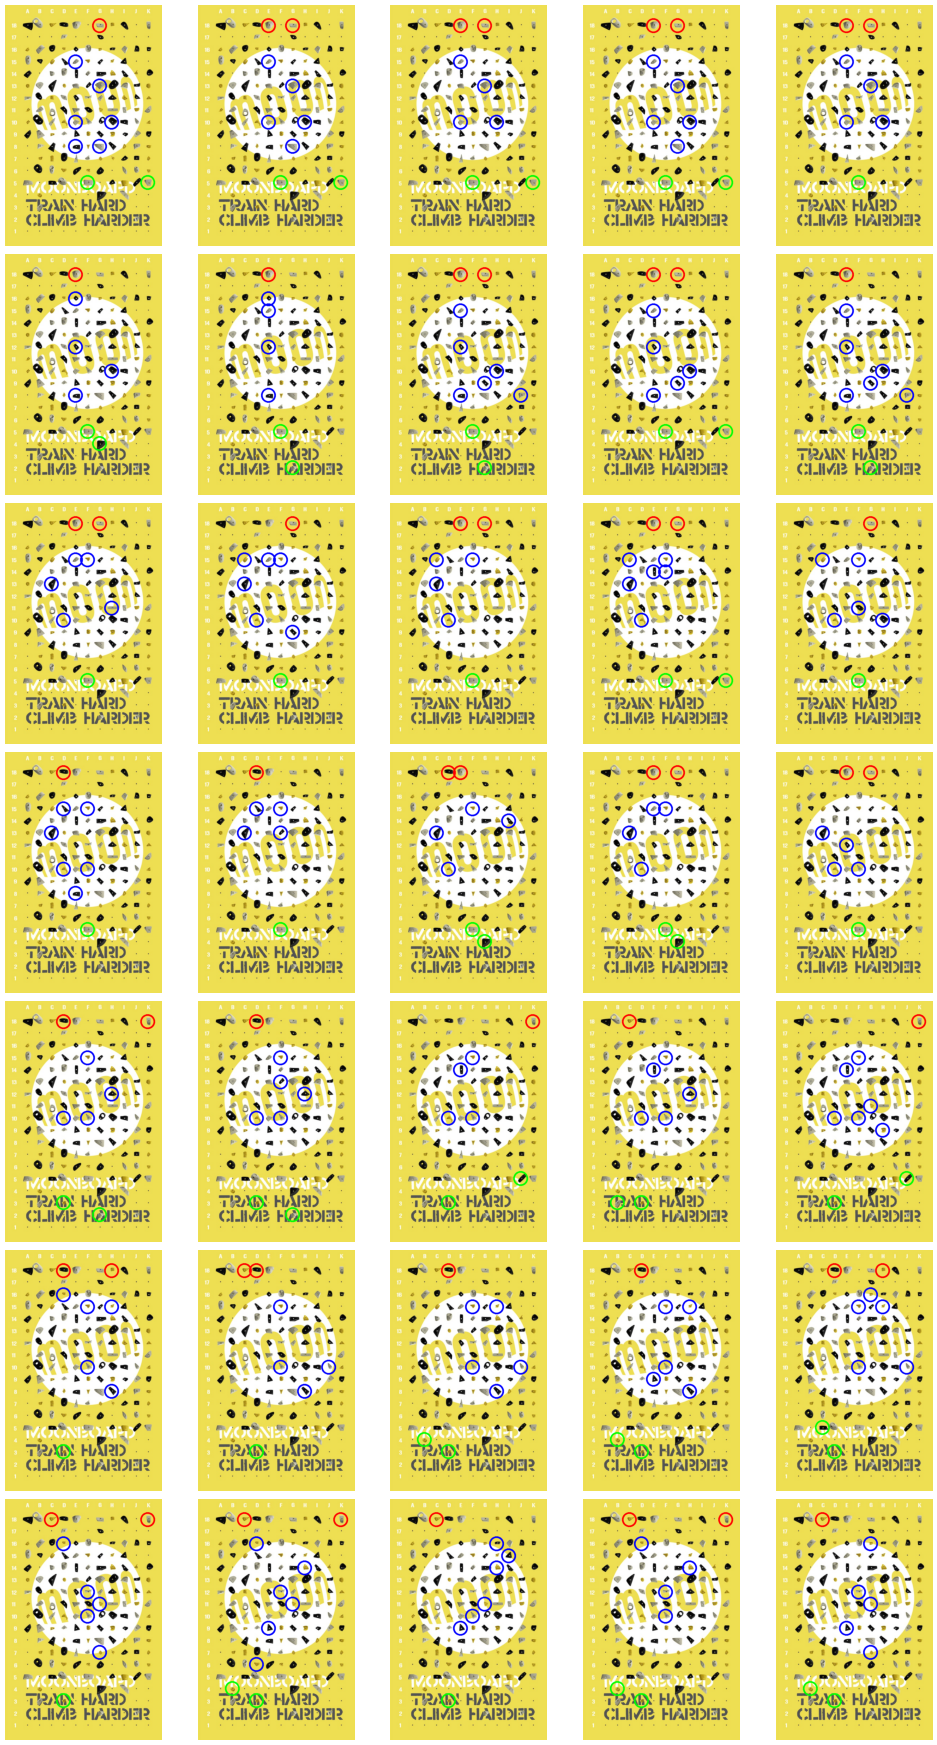

In [316]:
fig, axs = plt.subplots(N_SETS, N_TESTS, tight_layout=True, figsize=(20,35), dpi=50, facecolor='white')

decoders = {0: decoder_f_0,
            1: decoder_f_1,
            2: decoder_f_2,
            3: decoder_f_3,
            4: decoder_f_4,
            5: decoder_f_5,
            6: decoder_f_6,}

for i in range(0,N_SETS):
    decoder = decoders[i]
    for j in range(0, N_TESTS):
        input = all_latent_inputs[j]
        axs[i,j].imshow(display_generated_route(input, decoder, show_raw = False, show_holds = False, return_route=True))
        # axs[i,j].set(title='Grade=V'+str(i+4)+'; Input='+str(input))
        axs[i,j].axis('off')
plt.show() 

## LATENT_DIM = 20

In [317]:
latent_dim = 20

### Instantiating Models

In [318]:
encoder_f_0, decoder_f_0, vae_f_0 = vae_3_channels()
encoder_f_1, decoder_f_1, vae_f_1 = vae_3_channels()
encoder_f_2, decoder_f_2, vae_f_2 = vae_3_channels()
encoder_f_3, decoder_f_3, vae_f_3 = vae_3_channels()
encoder_f_4, decoder_f_4, vae_f_4 = vae_3_channels()
encoder_f_5, decoder_f_5, vae_f_5 = vae_3_channels()
encoder_f_6, decoder_f_6, vae_f_6 = vae_3_channels()

### Training

In [319]:
EPOCHS = 25
vae_f_0.fit(X0_train, X0_train, epochs = EPOCHS, validation_data=(X0_test, X0_test), verbose = False)
vae_f_1.fit(X1_train, X1_train, epochs = EPOCHS, validation_data=(X1_test, X1_test), verbose = False)
vae_f_2.fit(X2_train, X2_train, epochs = EPOCHS, validation_data=(X2_test, X2_test), verbose = False)
vae_f_3.fit(X3_train, X3_train, epochs = EPOCHS, validation_data=(X3_test, X3_test), verbose = False)
vae_f_4.fit(X4_train, X4_train, epochs = EPOCHS, validation_data=(X4_test, X4_test), verbose = False)
vae_f_5.fit(X5_train, X5_train, epochs = EPOCHS, validation_data=(X5_test, X5_test), verbose = False)
vae_f_6.fit(X6_train, X6_train, epochs = EPOCHS, validation_data=(X6_test, X6_test), verbose = False)

### Results

In [320]:
N_SETS = 7
N_TESTS = 5

all_latent_inputs = [[random.uniform(-4,4) for i in range(latent_dim)] for i in range(N_TESTS)]

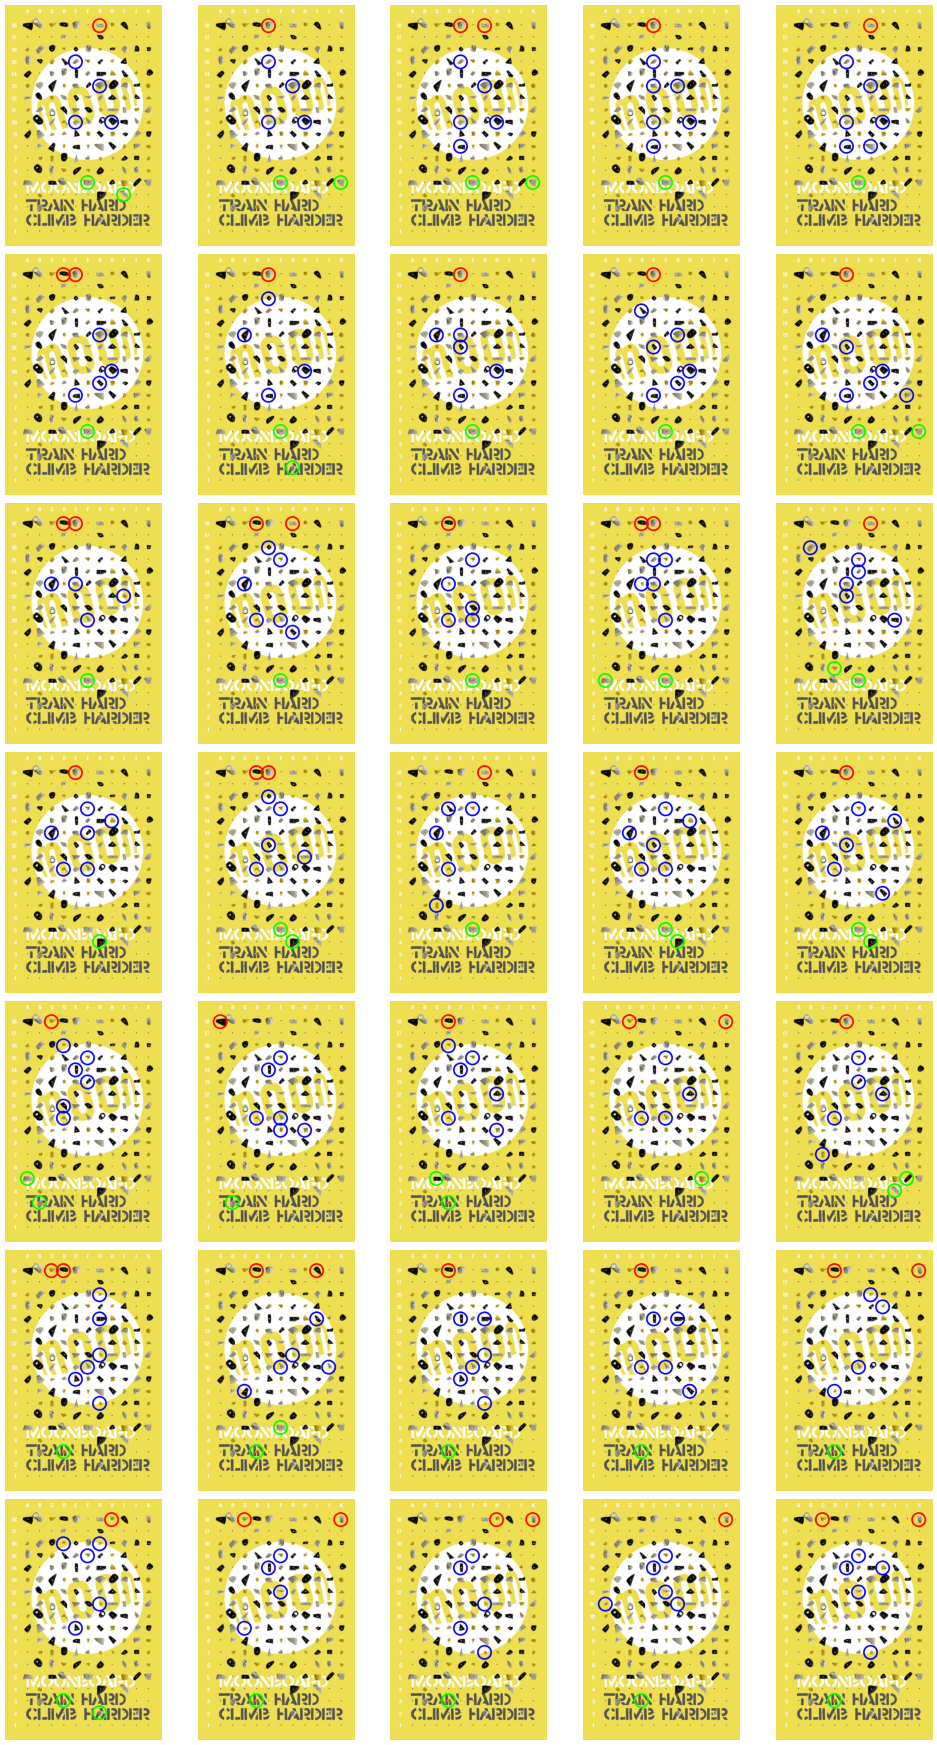

In [321]:
fig, axs = plt.subplots(N_SETS, N_TESTS, tight_layout=True, figsize=(20,35), dpi=50, facecolor='white')

decoders = {0: decoder_f_0,
            1: decoder_f_1,
            2: decoder_f_2,
            3: decoder_f_3,
            4: decoder_f_4,
            5: decoder_f_5,
            6: decoder_f_6,}

for i in range(0,N_SETS):
    decoder = decoders[i]
    for j in range(0, N_TESTS):
        input = all_latent_inputs[j]
        axs[i,j].imshow(display_generated_route(input, decoder, show_raw = False, show_holds = False, return_route=True))
        # axs[i,j].set(title='Grade=V'+str(i+4)+'; Input='+str(input))
        axs[i,j].axis('off')
plt.show() 